# Forecasting Demand for FairStorage

**YSC4224 Applied Data Science** <br>
*Final Project*

**Team 3** <br>
Elizabeth STEPTON, Jonathan CHIA, Joshua VARGAS, Raihanah FATINAH, Sean LIM

# Introduction to Notebook

## Import relevant libraries, datasets

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pmdarima.arima import auto_arima
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import seaborn as sns
import pmdarima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import multiprocesspandas
import xgboost as xgb
from xgboost import XGBRegressor
import time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## Load Data

In [4]:
train = pd.read_csv("data/train.csv")
price = pd.read_csv("data/prices.csv")
calendar = pd.read_csv("data/calendar.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

# Exploratory Data Analysis

In this section, we will explore the datasets `train`, `price`, and `calendar` and learn about the existing data collected by FairStorage. EDA involves the use of statistical and visualization techniques to summarize and examine the main characteristics of a dataset, such as its distribution, central tendency, and variability. Performing EDA will help us make informed decisions about how to use the data to answer research questions or build predictive models that can assist FairStorage in making data-driven business decisions.

The dataframe `train` has our training data.

In [5]:
train

,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,Beauty_1_004,Beauty_1,Beauty,East_1,East,0,0,0,0,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,Beauty_1_005,Beauty_1,Beauty,East_1,East,0,0,0,0,...,2,2,2,4,1,0,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,Food_3_823,Food_3,Food,West_3,West,0,0,2,2,...,1,0,0,1,0,0,0,2,2,0
30486,Food_3_824_West_3,Food_3_824,Food_3,Food,West_3,West,0,0,0,0,...,0,0,1,0,0,1,1,1,0,0
30487,Food_3_825_West_3,Food_3_825,Food_3,Food,West_3,West,0,6,0,2,...,0,0,1,0,0,0,1,1,0,2
30488,Food_3_826_West_3,Food_3_826,Food_3,Food,West_3,West,0,0,0,0,...,0,3,1,3,1,3,0,1,2,1


Let's take a look at the dataframe shape:

In [6]:
train.shape

(30490, 1925)

The dataframe contains information on 30490 products. There are also six columns of identification data and 1,919 days of time-series data. Let's look at the identification data, starting with region.

In [7]:
train["region_id"].unique()

array(['East', 'Central', 'West'], dtype=object)

FairStorage has strategically placed their stores in three different regions of Singapore to cater to a wider range of customers. These regions are located in East, West, and Central Singapore, allowing residents from various parts of Singapore to access their storage services conveniently. Let's look at their stores:

In [8]:
train["store_id"].unique()

array(['East_1', 'East_2', 'East_3', 'East_4', 'Central_1', 'Central_2',
       'Central_3', 'West_1', 'West_2', 'West_3'], dtype=object)

We can see that FairStorage has 10 stores. Let's look at the other product identifying information this time, starting with the categories of items:

In [9]:
train["category_id"].unique()

array(['Beauty', 'Cleaning', 'Food'], dtype=object)

Our dataset covers three categories of items sold by FairStorage: beauty, cleaning, and food. These are further divided into subcategories:

In [10]:
train["subcat_id"].unique()

array(['Beauty_1', 'Beauty_2', 'Cleaning_1', 'Cleaning_2', 'Food_1',
       'Food_2', 'Food_3'], dtype=object)

Let's now look at our `price` dataset:

In [11]:
price

,store_id,item_id,wm_yr_wk,sell_price
0,East_1,Beauty_1_001,11325,9.58
1,East_1,Beauty_1_001,11326,9.58
2,East_1,Beauty_1_001,11327,8.26
3,East_1,Beauty_1_001,11328,8.26
4,East_1,Beauty_1_001,11329,8.26
...,...,...,...,...
6841116,West_3,Food_3_827,11617,1.00
6841117,West_3,Food_3_827,11618,1.00
6841118,West_3,Food_3_827,11619,1.00
6841119,West_3,Food_3_827,11620,1.00


The `price` dataset has weekly price information for products. This can be used in conjunction with `train` to potentially predict how product prices affect demand. Let's create a column that matches the `id` format in `train`:

In [12]:
price["id"] = price["item_id"]+ "_" + price["store_id"]

In [13]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price,id
0,East_1,Beauty_1_001,11325,9.58,Beauty_1_001_East_1
1,East_1,Beauty_1_001,11326,9.58,Beauty_1_001_East_1
2,East_1,Beauty_1_001,11327,8.26,Beauty_1_001_East_1
3,East_1,Beauty_1_001,11328,8.26,Beauty_1_001_East_1
4,East_1,Beauty_1_001,11329,8.26,Beauty_1_001_East_1


Let's see the shape of this new dataframe:

In [14]:
price.shape

(6841121, 5)

Let's look at the last week for which we have price data:

In [15]:
price["wm_yr_wk"].max()

11621

The `calendar` dataframe is for our reference and includes the same date in date/time, `wm_yr_wk`, and human-readable formats.

In [16]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d
0,2011-01-29,11101,Saturday,1,1,2011,d_1
1,2011-01-30,11101,Sunday,2,1,2011,d_2
2,2011-01-31,11101,Monday,3,1,2011,d_3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5


This has the same number of weeks as the `price` data:

In [17]:
calendar["wm_yr_wk"].max()

11621

We now explore how the sales volume varies over time.

In [18]:
train

,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,Beauty_1_004,Beauty_1,Beauty,East_1,East,0,0,0,0,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,Beauty_1_005,Beauty_1,Beauty,East_1,East,0,0,0,0,...,2,2,2,4,1,0,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,Food_3_823,Food_3,Food,West_3,West,0,0,2,2,...,1,0,0,1,0,0,0,2,2,0
30486,Food_3_824_West_3,Food_3_824,Food_3,Food,West_3,West,0,0,0,0,...,0,0,1,0,0,1,1,1,0,0
30487,Food_3_825_West_3,Food_3_825,Food_3,Food,West_3,West,0,6,0,2,...,0,0,1,0,0,0,1,1,0,2
30488,Food_3_826_West_3,Food_3_826,Food_3,Food,West_3,West,0,0,0,0,...,0,3,1,3,1,3,0,1,2,1


In [17]:
sales_by_region = train.groupby("region_id").sum()
sales_by_region = sales_by_region.transpose().reset_index(drop = True)

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_1298/500141495.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_by_region = train.groupby("region_id").sum()


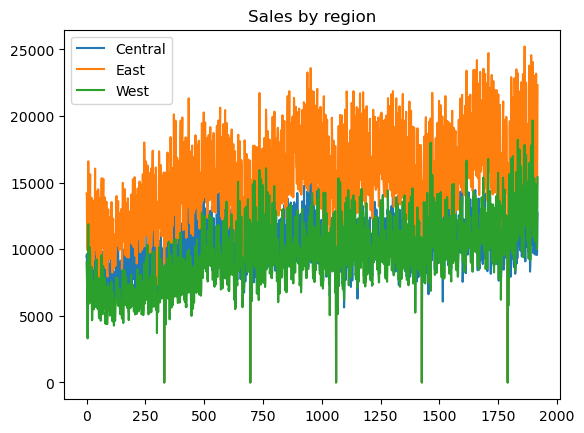

In [18]:
plt.plot(sales_by_region)
plt.title("Sales by region")
plt.legend(list(sales_by_region.columns))
plt.show()

We can see that stores in the East tend to have relatively more sales over time, while stores in the West tend to have lower sales. Interestingly, there appear to be strong dips in sales in West region stores at specific periods of time.

We're also interested to see if there is any correlations between sales in different region.

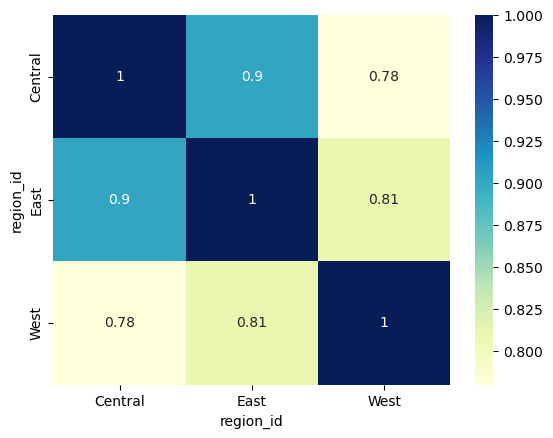

In [19]:
sns.heatmap(sales_by_region.corr(), cmap="YlGnBu", annot=True)
plt.show()

As we can see from the results above, there seems to be a high correlation between the sales in different regions, but strongest between the East and Central region. It would be interesting to explore if the total number of population plays into the sales being high for both of these regions.

In [20]:
sales_by_category = train.groupby("category_id").sum()
sales_by_category = sales_by_category.transpose().reset_index(drop = True)

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_1298/3271061109.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_by_category = train.groupby("category_id").sum()


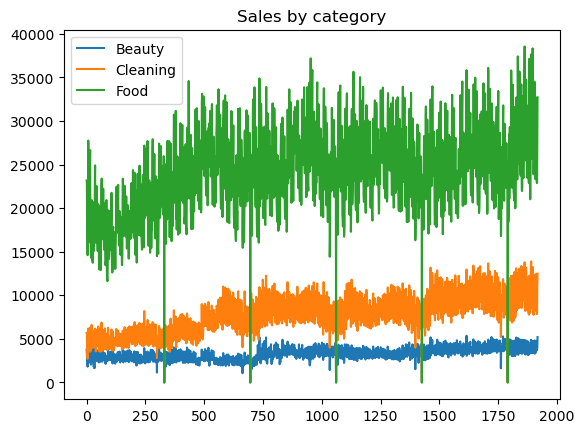

In [21]:
plt.plot(sales_by_category)
plt.title("Sales by category")
plt.legend(list(sales_by_category.columns))
plt.show()

We can see that food items tend to be much more popular than beauty and cleaning products. This could be due to a variety of factors, such as the perishable nature of food items or the fact that they are essential items that customers need to restock regularly. Very interestingly, there are intense dips in food sales at specific time periods.

Let's start looking at sales divided by region and category.

In [22]:
sales_by_region_category = train.groupby(by=["category_id", "region_id"]).sum()
sales_by_region_category = sales_by_region_category.transpose().reset_index(drop = True)
sales_by_region_category

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_1298/787763084.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_by_region_category = train.groupby(by=["category_id", "region_id"]).sum()


category_id  Beauty             Cleaning                Food              
region_id   Central  East  West  Central  East  West Central   East   West
0               879  1802  1083     1706  2292  1691    6853  10101   6224
1               870  1561   926     1730  2382  1522    7030   9862   5866
2               526  1472   684     1128  1692  1107    5124   6944   5106
3               809  1405   455     1102  1778   985    5470   7864   5544
4               501  1181   132      809  1566   354    4602   7178   2823
...             ...   ...   ...      ...   ...   ...     ...    ...    ...
1914           1007  1686   952     2445  3628  2250    6481   9698   7340
1915            994  1733  1003     2228  3562  2053    6353   9541   6978
1916           1089  1730   923     2488  3449  2138    6078   9485   7352
1917           1152  1866  1067     3254  4200  3689    7756  11114   8798
1918           1462  2457  1295     3281  5634  3577    7951  14236  10536

[1919 rows x 9 columns]

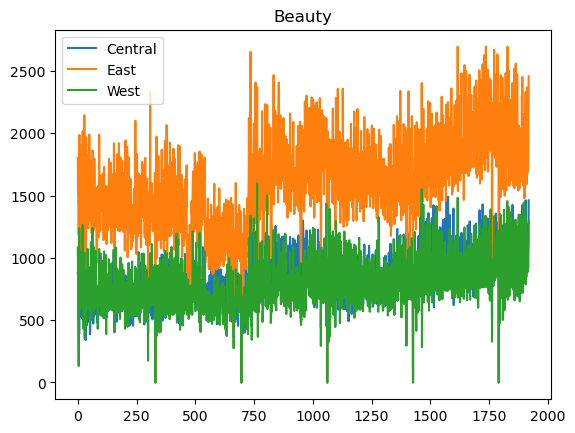

In [23]:
plt.plot(sales_by_region_category['Beauty'])
plt.title("Beauty")
plt.legend(sales_by_region.columns)
plt.show()

Beauty products appear markedly more popular in the East region, though this could also be because of generally higher sales in the East region (and the fact that there are four stores in the East, compared to three in Central or West).

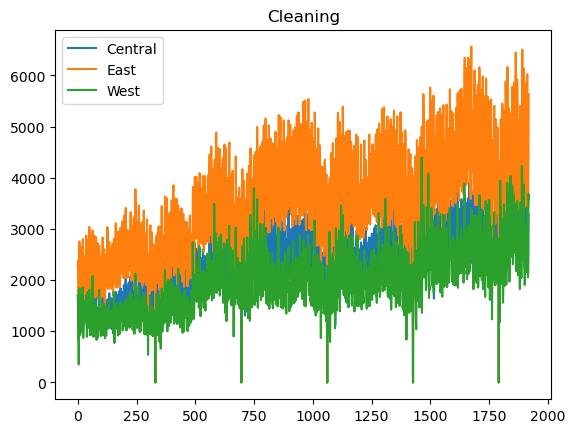

In [24]:
plt.plot(sales_by_region_category['Cleaning'])
plt.title("Cleaning")
plt.legend(sales_by_region.columns)
plt.show()

Cleaning products are again more popular in the East and relatively less popular in the West. Note more gradual dips in demand for cleaning products in the West compared to other categories of products.

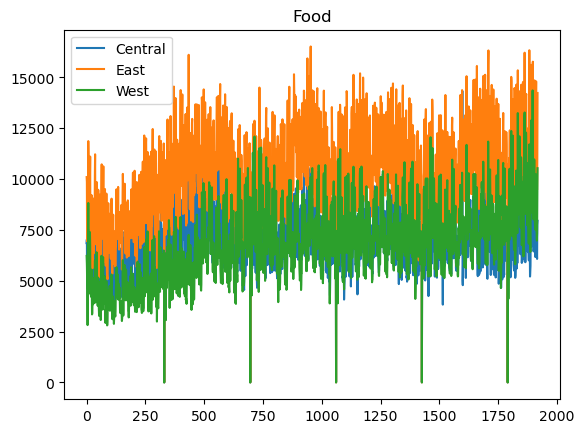

In [25]:
plt.plot(sales_by_region_category['Food'])
plt.title("Food")
plt.legend(sales_by_region.columns)
plt.show()

There appears to be stronger demand for Food products than other categories of products in the West region, and at points in time sales of food in West appear to overtake sales of food in Central. Note in all of these graphs that stores in the West consistently display dips in demand at specific points in time. This may indicate either an error in data collection or something unnatural happening in West region stores, perhaps holiday-triggered closures.

We're also interested in seeing the correlation of different item sales by region and category. 

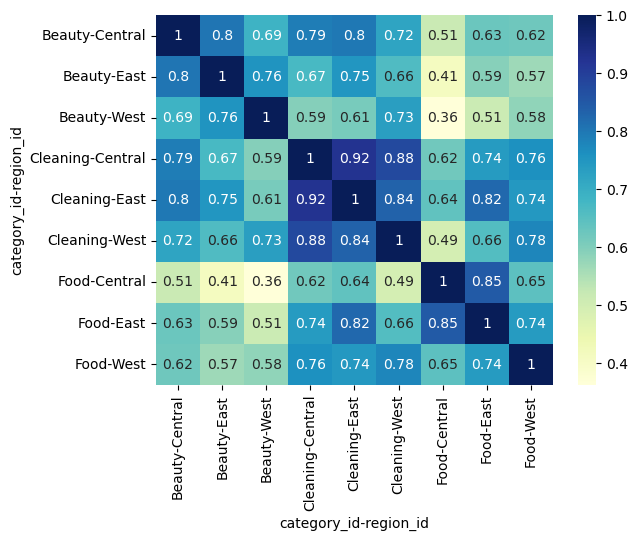

In [26]:
# sales_by_region_category.corr()

sns.heatmap(sales_by_region_category.corr(), cmap="YlGnBu", annot=True)
plt.show()

Let's see how total sales vary over time:

In [5]:
train2 = train.copy()
train2.drop(['item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'], axis = 1, inplace = True)
train2 = train2.transpose()

In [6]:
colnames = train2.iloc[0]
train2.rename(columns = colnames, inplace = True)
train2 = train2.iloc[1:]

In [7]:
train2.reset_index(inplace = True)
train2.rename({"index":"d"}, axis = 1, inplace = True)

In [8]:
train2

,d,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,...,Food_3_818_West_3,Food_3_819_West_3,Food_3_820_West_3,Food_3_821_West_3,Food_3_822_West_3,Food_3_823_West_3,Food_3_824_West_3,Food_3_825_West_3,Food_3_826_West_3,Food_3_827_West_3
0,d_1,0,0,0,0,0,0,0,12,2,...,0,14,1,0,4,0,0,0,0,0
1,d_2,0,0,0,0,0,0,0,15,0,...,0,11,1,0,4,0,0,6,0,0
2,d_3,0,0,0,0,0,0,0,0,7,...,0,5,1,0,2,2,0,0,0,0
3,d_4,0,0,0,0,0,0,0,0,3,...,0,6,1,0,5,2,0,2,0,0
4,d_5,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,d_1915,0,1,0,0,0,0,0,3,2,...,4,2,2,0,2,0,1,0,3,0
1915,d_1916,0,0,1,1,2,1,0,2,6,...,0,0,1,0,2,0,1,1,0,0
1916,d_1917,2,0,1,2,3,0,0,8,0,...,1,0,1,3,2,2,1,1,1,0
1917,d_1918,0,0,0,4,1,0,1,8,0,...,2,1,1,1,2,2,0,0,2,0


In [31]:
# train_with_date = train2.sum(axis = 1).merge(calendar, on = "d")
# train_with_date
daily_sales = train2.drop("d", axis = 1).sum(axis = 1)
train_with_total = train2.copy()
train_with_total["total"] = daily_sales
train_with_total = train_with_total.merge(calendar, on = "d")

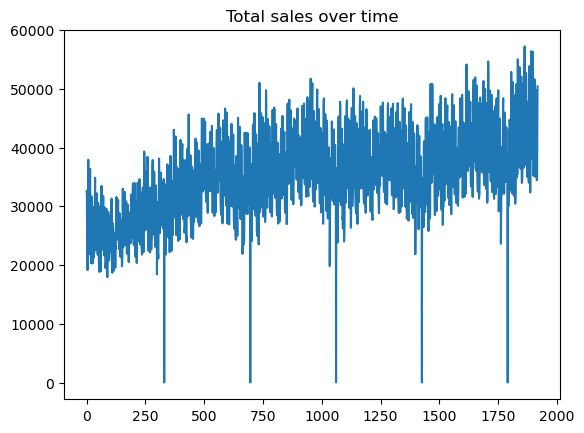

In [32]:
plt.plot(train_with_total["total"])
plt.title("Total sales over time")
plt.show()

Sales appear to generally be increasing at FairStorage. Let's look at sales figures by month to understand seasonal changes in sales:

In [33]:
avg_sales_by_month = train_with_total.groupby("month").mean()
avg_sales_by_month

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_1298/1979195265.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_sales_by_month = train_with_total.groupby("month").mean()


,total,wm_yr_wk,wday,year
month,,,,
1,33832.348101,11350.056962,4.000000,2013.943038
2,34644.641176,11353.494118,4.000000,2013.505882
3,34339.838710,11357.145161,3.983871,2013.500000
4,34432.183333,11361.500000,4.000000,2013.500000
5,32503.851613,11315.851613,4.038710,2013.000000
6,35001.413333,11320.220000,3.960000,2013.000000
7,35122.419355,11324.567742,4.025806,2013.000000
8,35946.645161,11329.000000,4.000000,2013.000000
9,35479.260000,11333.360000,3.980000,2013.000000


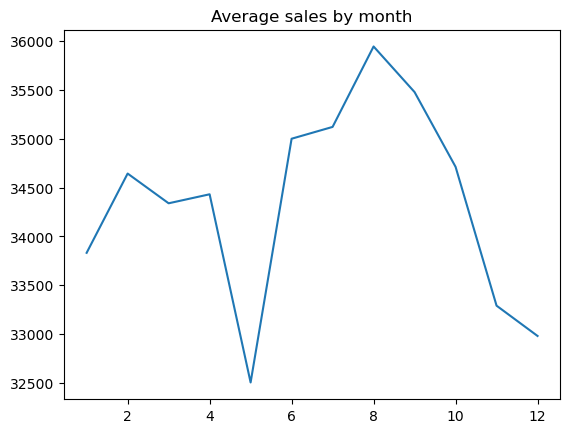

In [34]:
plt.plot(avg_sales_by_month["total"])
plt.title("Average sales by month")
plt.show()

It appears that the strong dip in sales may be in the month of May. Interestingly, sales dip in the lead-up to Christmas.

In the following blocks, we will manipulate the data to make further data visualisations.

In [25]:
price2 = price.pivot(index = "wm_yr_wk", columns = "id", values = "sell_price")

We have to match the columns again because the pivot messes up the order.

In [26]:
price2 = price2[train2.columns[1:30491]]

In [27]:
price2

id,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,Beauty_1_010_East_1,...,Food_3_818_West_3,Food_3_819_West_3,Food_3_820_West_3,Food_3_821_West_3,Food_3_822_West_3,Food_3_823_West_3,Food_3_824_West_3,Food_3_825_West_3,Food_3_826_West_3,Food_3_827_West_3
wm_yr_wk,,,,,,,,,,,,,,,,,,,,,
11101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,3.98,2.50,2.47,4.00,NaN,NaN
11102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,3.98,2.50,2.47,4.00,NaN,NaN
11103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,1.56,3.17,...,NaN,1.98,1.57,NaN,2.98,2.50,2.47,4.00,NaN,NaN
11104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.42,1.56,3.17,...,NaN,1.98,1.57,NaN,2.98,2.50,2.48,4.00,NaN,NaN
11105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.42,1.56,3.17,...,NaN,1.98,1.57,NaN,2.98,2.50,2.48,4.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11617,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
11618,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
11619,8.38,3.97,2.97,4.64,2.88,0.96,7.88,0.48,1.77,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0


Create `supp_info` dataframe which tells us how the dates are related.

In [28]:
supp_info = train2.merge(calendar, how = "inner", on = "d")
supp_info = supp_info.drop(supp_info.columns[1:30491],axis = 1)

In [29]:
supp_info

,d,date,wm_yr_wk,weekday,wday,month,year
0,d_1,2011-01-29,11101,Saturday,1,1,2011
1,d_2,2011-01-30,11101,Sunday,2,1,2011
2,d_3,2011-01-31,11101,Monday,3,1,2011
3,d_4,2011-02-01,11101,Tuesday,4,2,2011
4,d_5,2011-02-02,11101,Wednesday,5,2,2011
...,...,...,...,...,...,...,...
1914,d_1915,2016-04-26,11613,Tuesday,4,4,2016
1915,d_1916,2016-04-27,11613,Wednesday,5,4,2016
1916,d_1917,2016-04-28,11613,Thursday,6,4,2016
1917,d_1918,2016-04-29,11613,Friday,7,4,2016


In [30]:
price3 = supp_info.merge(price2, on = "wm_yr_wk", how = "left")
price3.fillna(0, inplace = True)

In [31]:
price3

,d,date,wm_yr_wk,weekday,wday,month,year,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,...,Food_3_818_West_3,Food_3_819_West_3,Food_3_820_West_3,Food_3_821_West_3,Food_3_822_West_3,Food_3_823_West_3,Food_3_824_West_3,Food_3_825_West_3,Food_3_826_West_3,Food_3_827_West_3
0,d_1,2011-01-29,11101,Saturday,1,1,2011,0.00,0.00,0.00,...,0.00,1.98,1.57,0.00,3.98,2.50,2.47,4.00,0.00,0.0
1,d_2,2011-01-30,11101,Sunday,2,1,2011,0.00,0.00,0.00,...,0.00,1.98,1.57,0.00,3.98,2.50,2.47,4.00,0.00,0.0
2,d_3,2011-01-31,11101,Monday,3,1,2011,0.00,0.00,0.00,...,0.00,1.98,1.57,0.00,3.98,2.50,2.47,4.00,0.00,0.0
3,d_4,2011-02-01,11101,Tuesday,4,2,2011,0.00,0.00,0.00,...,0.00,1.98,1.57,0.00,3.98,2.50,2.47,4.00,0.00,0.0
4,d_5,2011-02-02,11101,Wednesday,5,2,2011,0.00,0.00,0.00,...,0.00,1.98,1.57,0.00,3.98,2.50,2.47,4.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,d_1915,2016-04-26,11613,Tuesday,4,4,2016,8.38,3.97,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
1915,d_1916,2016-04-27,11613,Wednesday,5,4,2016,8.38,3.97,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
1916,d_1917,2016-04-28,11613,Thursday,6,4,2016,8.38,3.97,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0
1917,d_1918,2016-04-29,11613,Friday,7,4,2016,8.38,3.97,2.97,...,2.98,1.98,1.98,4.98,3.98,2.98,2.48,3.98,1.28,1.0


In [32]:
supp_cols = ["d", "date", "wm_yr_wk", "weekday", "wday", "month", "year"]

It would be interesting to calculate what's correlation between each item sales to price. Since there are so many products out there, what we're doing is we're calculating the average correlation between item sold to price. 

In [33]:
accumulate = []

for column in train2.columns[1:]:
    correlation = train2[column].astype(float).corr(price3[column])
    if not np.isnan(correlation):
        accumulate.append(abs(correlation))
        
print(np.mean(accumulate))

0.223991558866708


From the results above, we see that there is a low correlation between sales of each time and price. This means that the number of sales is not affected by the price (on average).

Obtaining revenue data, the product of price and quantities.

In [34]:
price4 = price3.drop(supp_cols, axis = 1)
train3 = train2.drop("d", axis = 1)
revs = price4 * train3

In [35]:
revs1 = revs.transpose()
revs1.reset_index(inplace = True)
revs1.rename({"index":"id"}, axis = 1, inplace = True)

In [36]:
extracted_cols = train[["item_id", "subcat_id", "category_id", "store_id", "region_id"]]
revs2 = extracted_cols.join(revs1)

In [37]:
revs2

,item_id,subcat_id,category_id,store_id,region_id,id,0,1,2,3,...,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918
0,Beauty_1_001,Beauty_1,Beauty,East_1,East,Beauty_1_001_East_1,0.0,0.0,0.0,0.0,...,25.14,0.0,8.38,8.38,0.0,0.0,0.0,16.76,0.0,25.14
1,Beauty_1_002,Beauty_1,Beauty,East_1,East,Beauty_1_002_East_1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.97,0.0,0.0,0.0,0.0
2,Beauty_1_003,Beauty_1,Beauty,East_1,East,Beauty_1_003_East_1,0.0,0.0,0.0,0.0,...,0.0,2.97,2.97,2.97,0.0,0.0,2.97,2.97,0.0,5.94
3,Beauty_1_004,Beauty_1,Beauty,East_1,East,Beauty_1_004_East_1,0.0,0.0,0.0,0.0,...,4.64,13.92,32.48,9.28,0.0,0.0,4.64,9.28,18.56,4.64
4,Beauty_1_005,Beauty_1,Beauty,East_1,East,Beauty_1_005_East_1,0.0,0.0,0.0,0.0,...,5.76,5.76,5.76,11.52,2.88,0.0,5.76,8.64,2.88,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823,Food_3,Food,West_3,West,Food_3_823_West_3,0.0,0.0,5.0,5.0,...,2.98,0.0,0.0,2.98,0.0,0.0,0.0,5.96,5.96,0.0
30486,Food_3_824,Food_3,Food,West_3,West,Food_3_824_West_3,0.0,0.0,0.0,0.0,...,0.0,0.0,2.48,0.0,0.0,2.48,2.48,2.48,0.0,0.0
30487,Food_3_825,Food_3,Food,West_3,West,Food_3_825_West_3,0.0,24.0,0.0,8.0,...,0.0,0.0,3.98,0.0,0.0,0.0,3.98,3.98,0.0,7.96
30488,Food_3_826,Food_3,Food,West_3,West,Food_3_826_West_3,0.0,0.0,0.0,0.0,...,0.0,3.84,1.28,3.84,1.28,3.84,0.0,1.28,2.56,1.28


In [43]:
total_rev = revs.sum(axis = 1)
rev_with_total = revs.copy()
rev_with_total["total"] = total_rev
rev_with_total["d"] = price3["d"]
rev_with_total = rev_with_total.merge(calendar, on = "d")

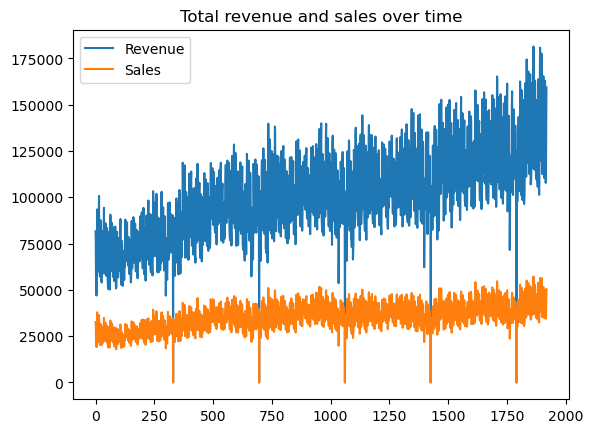

In [49]:
plt.plot(rev_with_total["total"], label = "Revenue")
plt.plot(train_with_total["total"], label = "Sales")
plt.title("Total revenue and sales over time")
plt.legend()
plt.show()

We created this plot of total revenue and sales over time. We can see that there is decent revenue and sales growth at FairStorage.

In [50]:
avg_rev_by_month = rev_with_total.groupby("month").mean()
avg_rev_by_month

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_1298/925233075.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rev_by_month = rev_with_total.groupby("month").mean()


,total,wm_yr_wk,wday,year
month,,,,
1,97660.473861,11350.056962,4.000000,2013.943038
2,100198.303647,11353.494118,4.000000,2013.505882
3,99752.642258,11357.145161,3.983871,2013.500000
4,100090.548222,11361.500000,4.000000,2013.500000
5,92869.613419,11315.851613,4.038710,2013.000000
6,97117.191200,11320.220000,3.960000,2013.000000
7,97803.671742,11324.567742,4.025806,2013.000000
8,100104.835290,11329.000000,4.000000,2013.000000
9,99712.356800,11333.360000,3.980000,2013.000000


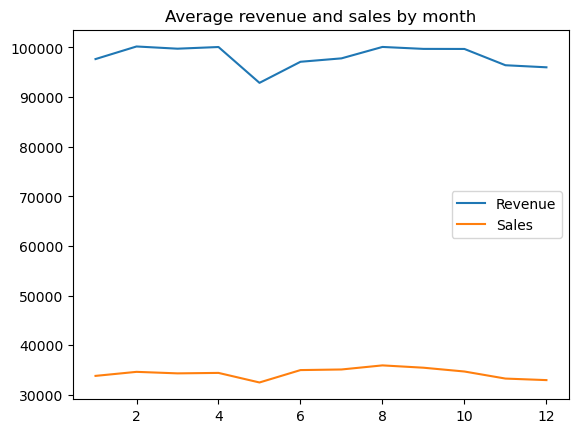

In [51]:
plt.plot(avg_rev_by_month["total"], label = "Revenue")
plt.plot(avg_sales_by_month["total"], label = "Sales")
plt.legend()
plt.title("Average revenue and sales by month")
plt.show()

Revenue and sales drop in the month of May.

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_1298/155359327.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rev_monthly_total = rev_with_total.groupby(by = ["year","month"]).sum()


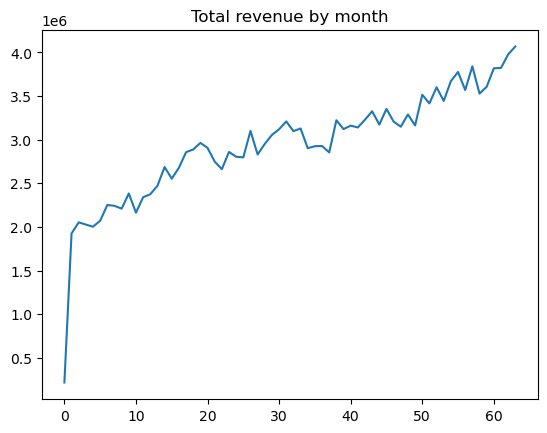

In [52]:
rev_monthly_total = rev_with_total.groupby(by = ["year","month"]).sum()
plt.plot(list(rev_monthly_total["total"]))
plt.title("Total revenue by month")
plt.show()

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_1298/789423432.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_monthly_total = train_with_total.groupby(by = ["year", "month"]).sum()


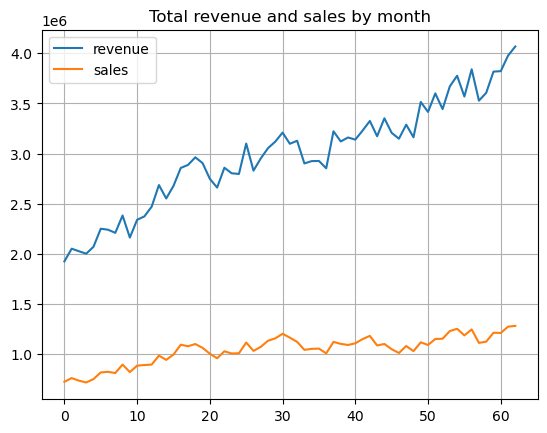

In [53]:
train_monthly_total = train_with_total.groupby(by = ["year", "month"]).sum()
plt.plot(list(rev_monthly_total["total"][1:]), label = "revenue")
plt.plot(list(train_monthly_total["total"][1:]), label = "sales")
plt.grid()
plt.legend()
plt.title("Total revenue and sales by month")
plt.show()

The business has been performing well and growing consistently over the last 5 years. The supermarket chain's revenue is growing at 15.4% CAGR, far exceeding inflation and population growth.

Given the historical trend, we expect the business to grow between 10-14% this calendar year, indicating revenues of roughly $47,506,000.

In [54]:
rev_by_category = revs2.drop(["item_id", "subcat_id", "region_id", "store_id", "id"], axis = 1).groupby("category_id", sort = False).sum()
rev_by_category

,0,1,2,3,4,5,6,7,8,9,...,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918
category_id,,,,,,,,,,,,,,,,,,,,,
Beauty,9795.95,8545.85,6720.02,6699.20,5137.88,7403.18,7856.91,10108.92,8029.69,6735.10,...,14484.87,16664.17,21136.86,21594.51,16784.52,15459.51,15603.54,16228.77,18148.64,22238.34
Cleaning,23805.16,23957.65,16052.15,15677.17,11267.16,16220.07,19344.70,27014.81,20911.56,16787.67,...,32949.66,39340.88,50180.42,53011.13,37325.90,34179.62,31531.77,33337.75,44239.75,51842.86
Food,48049.50,46467.07,34934.74,38384.83,30554.91,45754.13,41587.45,56324.02,54556.31,41641.93,...,62975.74,71035.25,83876.39,88318.43,69251.55,63010.95,60649.12,60946.30,73185.44,85295.49


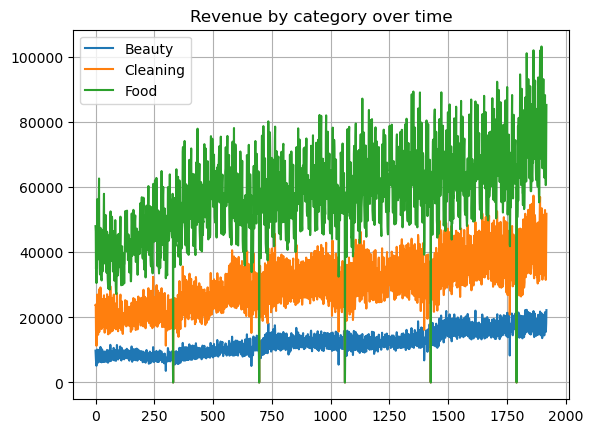

In [55]:
plt.plot(rev_by_category.transpose())
plt.legend(list(rev_by_category.index))
plt.title("Revenue by category over time")
plt.grid()
plt.show()

Visualising how revenue differes by region over time.

In [56]:
rev_by_region = revs2.drop(["item_id", "subcat_id", "category_id", "store_id", "id"], axis = 1).groupby("region_id", sort = False).sum()
rev_by_region

,0,1,2,3,4,5,6,7,8,9,...,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918
region_id,,,,,,,,,,,,,,,,,,,,,
East,36276.10,35047.46,25283.73,26917.00,25175.63,27496.33,31251.72,42484.77,38055.92,29617.30,...,46834.62,55652.00,72937.13,78494.60,57761.95,50120.99,48522.10,48644.00,57081.23,73431.68
Central,24100.45,23771.68,16609.83,17957.96,14455.86,22009.02,16004.57,23962.94,25552.82,19250.88,...,31205.16,33884.35,39042.59,41611.38,34902.54,32188.39,30763.33,31519.08,39215.89,41759.55
West,21274.06,20151.43,15813.35,15886.24,7328.46,19872.03,21532.77,27000.04,19888.82,16296.52,...,32370.49,37503.95,43213.95,42818.09,30697.48,30340.70,28499.00,30349.74,39276.71,44185.46


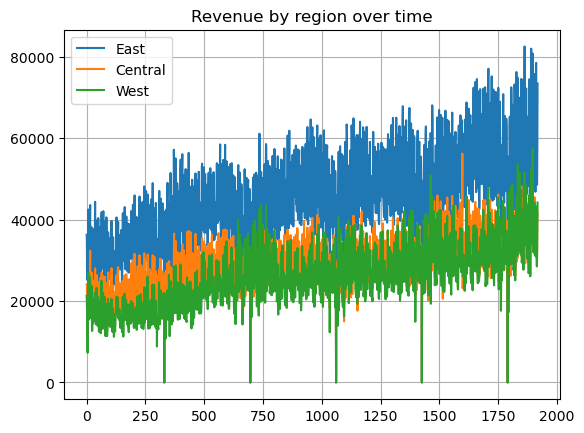

In [57]:
plt.plot(rev_by_region.transpose())
plt.legend(list(rev_by_region.index))
plt.title("Revenue by region over time")
plt.grid()
plt.show()

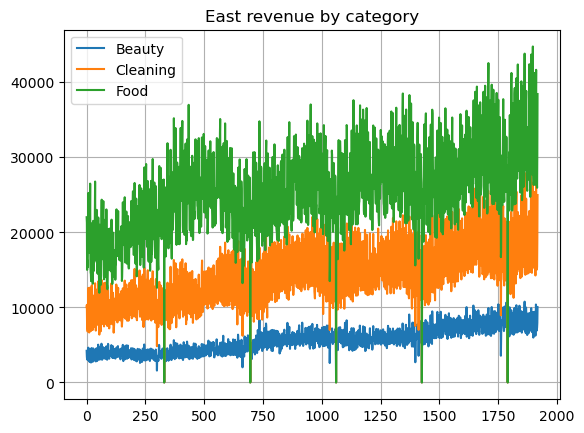

In [58]:
east_total_rev = revs2.loc[revs2["region_id"] == "East"]
east_total_rev_by_cat = east_total_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(east_total_rev_by_cat.transpose())
plt.title("East revenue by category")
plt.legend(list(east_total_rev_by_cat.index))
plt.grid()
plt.show()

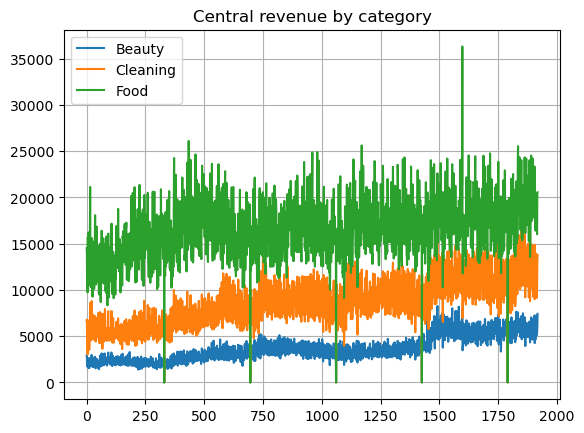

In [59]:
central_total_rev = revs2.loc[revs2["region_id"] == "Central"]
central_total_rev_by_cat = central_total_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(central_total_rev_by_cat.transpose())
plt.title("Central revenue by category")
plt.legend(list(central_total_rev_by_cat.index))
plt.grid()
plt.show()

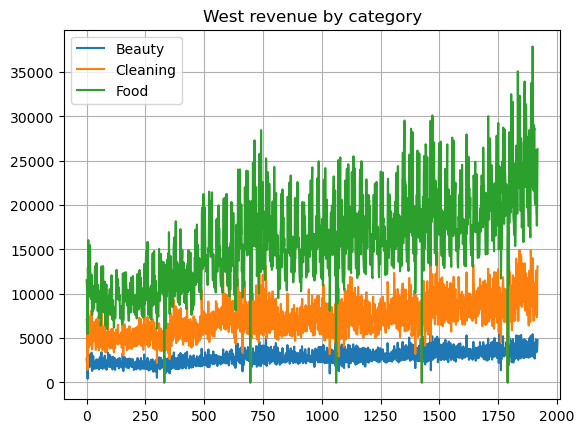

In [60]:
west_total_rev = revs2.loc[revs2["region_id"] == "West"]
west_total_rev_by_cat = west_total_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(west_total_rev_by_cat.transpose())
plt.title("West revenue by category")
plt.legend(list(west_total_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how the revenue differs by store across our training horizon.

In [61]:
rev_by_store = revs2.drop(["item_id", "subcat_id", "category_id", "region_id", "id"], axis = 1).groupby("store_id", sort = False).sum()
rev_by_store

,0,1,2,3,4,5,6,7,8,9,...,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918
store_id,,,,,,,,,,,,,,,,,,,,,
East_1,10933.16,9787.06,7201.38,7407.74,6566.12,7945.73,8546.76,13375.40,10591.43,7704.54,...,11687.99,14205.08,18317.93,20029.72,13887.08,11996.21,12037.84,11842.57,15531.11,18653.94
East_2,9101.52,8417.53,5320.51,5550.56,5229.72,5722.88,7099.03,10396.81,8288.25,5987.10,...,10746.54,14654.14,19846.12,20513.38,12858.75,11855.37,11445.13,12615.20,13850.23,20725.21
East_3,11679.83,12161.46,9123.86,10249.78,9538.65,10407.26,11640.09,13721.66,14462.15,11940.49,...,16230.51,18491.01,24861.53,26999.77,21662.51,17924.10,16858.21,16662.98,19288.78,24333.26
East_4,4561.59,4681.41,3637.98,3708.92,3841.14,3420.46,3965.84,4990.90,4714.09,3985.17,...,8169.58,8301.77,9911.55,10951.73,9353.61,8345.31,8180.92,7523.25,8411.11,9719.27
Central_1,6586.68,6610.60,4551.97,5374.39,4347.07,6769.82,4435.84,7226.66,7866.75,5456.29,...,8260.00,9499.88,11373.50,13011.24,9354.89,8934.54,8942.52,7901.84,11775.60,12424.21
Central_2,9915.78,9804.54,6651.16,6985.60,6039.05,8363.24,6608.13,9818.03,10130.28,7874.00,...,11409.73,12494.57,14575.46,14696.53,12968.33,11595.40,10495.51,11490.03,12775.54,15266.48
Central_3,7597.99,7356.54,5406.70,5597.97,4069.74,6875.96,4960.60,6918.25,7555.79,5920.59,...,11535.43,11889.90,13093.63,13903.61,12579.32,11658.45,11325.30,12127.21,14664.75,14068.86
West_1,6454.72,5645.77,3640.12,2949.96,2.96,4584.89,5925.37,7852.61,4030.75,3788.93,...,10361.39,12292.56,14332.14,14858.97,9498.48,9446.94,9484.43,9651.43,12292.07,16026.76
West_2,5451.46,4636.86,4621.58,5754.75,2679.19,5250.77,5552.65,6342.72,4772.57,4688.76,...,12796.87,14251.83,15761.02,15066.13,11950.82,11942.89,10862.16,12624.97,16617.89,15435.87


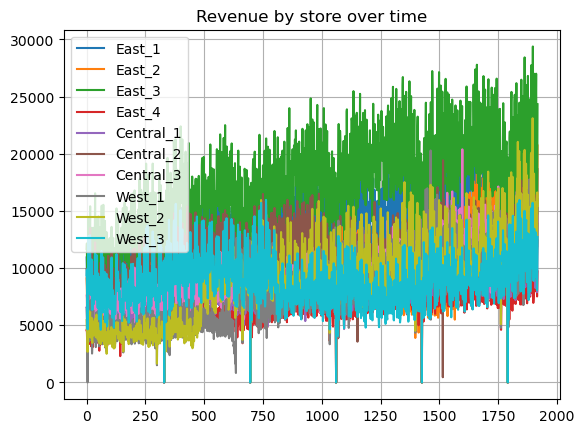

In [62]:
plt.plot(rev_by_store.transpose())
plt.legend(list(rev_by_store.index))
plt.title("Revenue by store over time")
plt.grid()
plt.show()

Visualising how East 1 performs across the 3 big categories.

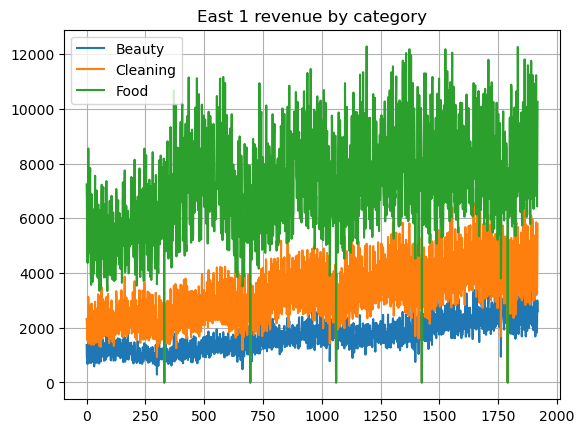

In [63]:
east_1_rev = revs2.loc[revs2["store_id"] == "East_1"]
east_1_rev_by_cat = east_1_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(east_1_rev_by_cat.transpose())
plt.title("East 1 revenue by category")
plt.legend(list(east_1_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how East 2 performs across the 3 big categories.

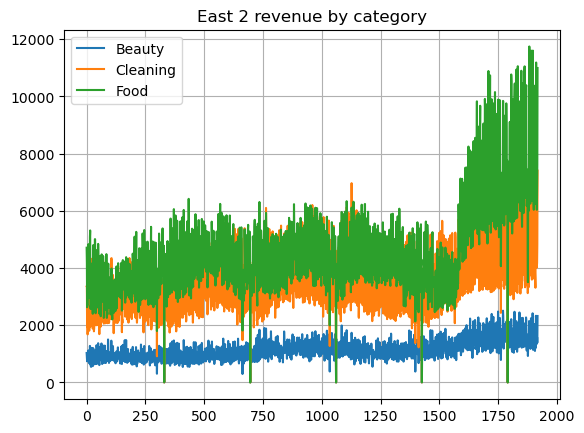

In [64]:
east_2_rev = revs2.loc[revs2["store_id"] == "East_2"]
east_2_rev_by_cat = east_2_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(east_2_rev_by_cat.transpose())
plt.legend(list(east_2_rev_by_cat.index))
plt.title("East 2 revenue by category")
plt.grid()
plt.show()

Visualising how East 3 performs across the big 3 categories.

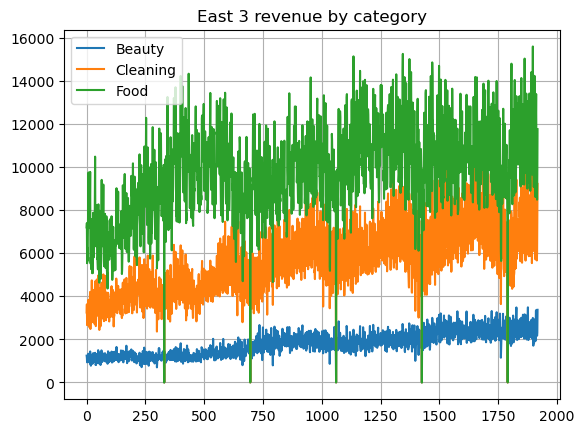

In [65]:
east_3_rev = revs2.loc[revs2["store_id"] == "East_3"]
east_3_rev_by_cat = east_3_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(east_3_rev_by_cat.transpose())
plt.legend(list(east_3_rev_by_cat.index))
plt.title("East 3 revenue by category")
plt.grid()
plt.show()

Visualising how East 4 performs across the big 3 categories.

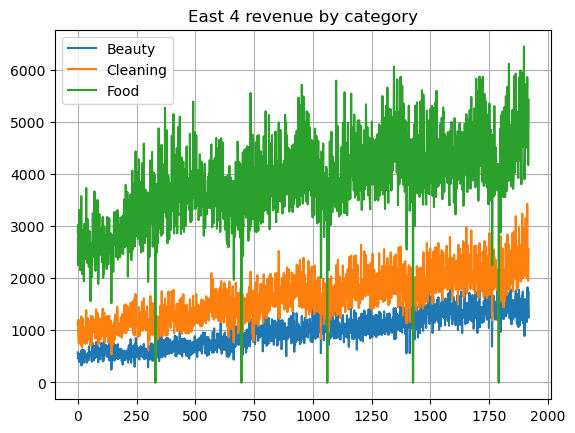

In [66]:
east_4_rev = revs2.loc[revs2["store_id"] == "East_4"]
east_4_rev_by_cat = east_4_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(east_4_rev_by_cat.transpose())
plt.title("East 4 revenue by category")
plt.legend(list(east_4_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how Central 1 performs across the big 3 categories

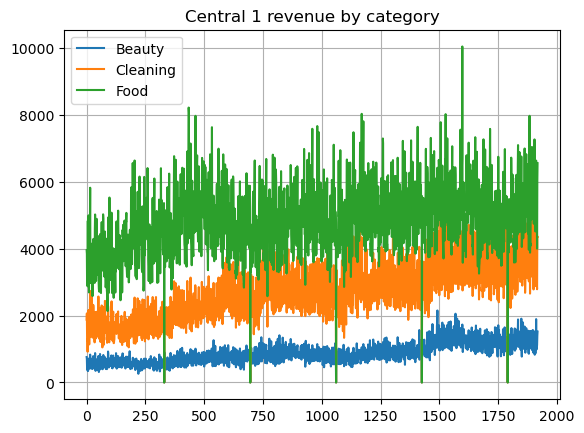

In [67]:
central_1_rev = revs2.loc[revs2["store_id"] == "Central_1"]
central_1_rev_by_cat = central_1_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(central_1_rev_by_cat.transpose())
plt.title("Central 1 revenue by category")
plt.legend(list(central_1_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how Central 2 performs across the big 3 categories

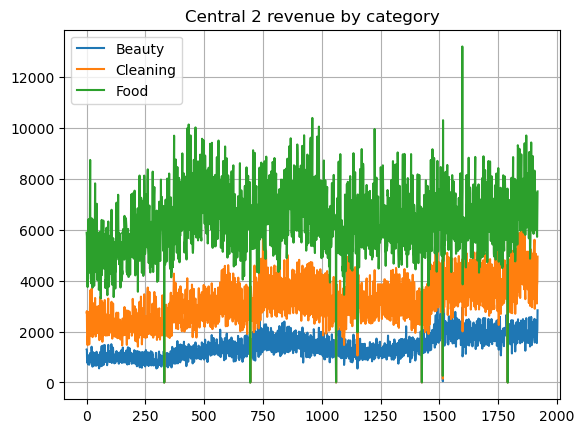

In [68]:
central_2_rev = revs2.loc[revs2["store_id"] == "Central_2"]
central_2_rev_by_cat = central_2_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(central_2_rev_by_cat.transpose())
plt.title("Central 2 revenue by category")
plt.legend(list(central_2_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how Central 3 performs across the big 3 categories

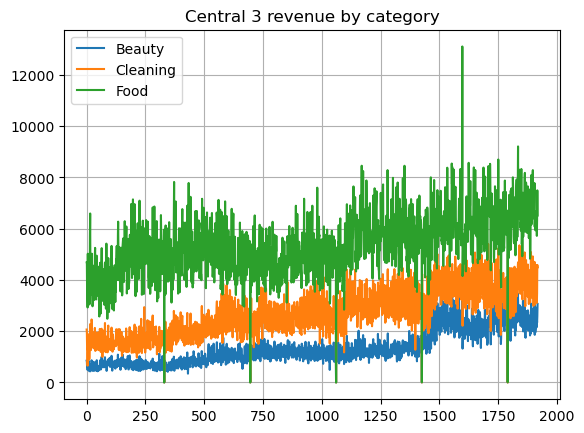

In [69]:
central_3_rev = revs2.loc[revs2["store_id"] == "Central_3"]
central_3_rev_by_cat = central_3_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(central_3_rev_by_cat.transpose())
plt.title("Central 3 revenue by category")
plt.legend(list(central_3_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how West 1 performs across the big 3 categories

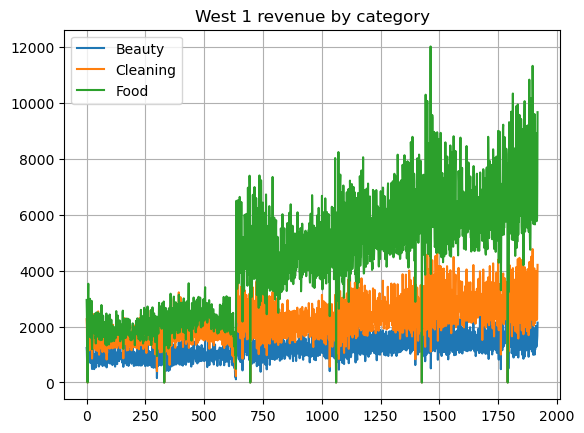

In [70]:
west_1_rev = revs2.loc[revs2["store_id"] == "West_1"]
west_1_rev_by_cat = west_1_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(west_1_rev_by_cat.transpose())
plt.title("West 1 revenue by category")
plt.legend(list(west_1_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how West 2 performs across the big 3 categories

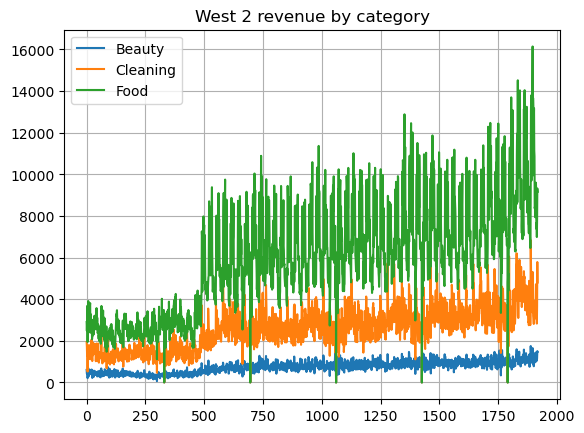

In [71]:
west_2_rev = revs2.loc[revs2["store_id"] == "West_2"]
west_2_rev_by_cat = west_2_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(west_2_rev_by_cat.transpose())
plt.title("West 2 revenue by category")
plt.legend(list(west_2_rev_by_cat.index))
plt.grid()
plt.show()

Visualising how West 3 performs across the big 3 categories

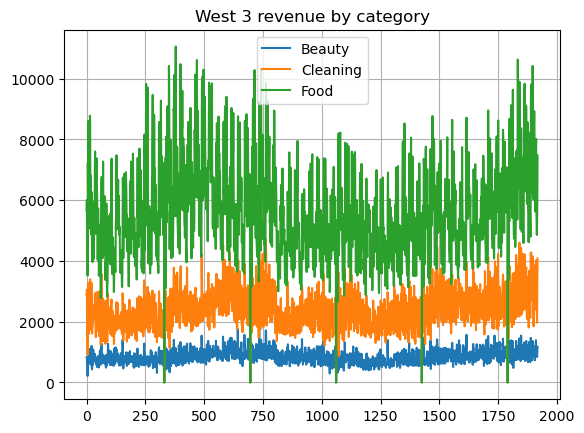

In [72]:
west_3_rev = revs2.loc[revs2["store_id"] == "West_3"]
west_3_rev_by_cat = west_3_rev.drop(["item_id", "subcat_id", "store_id", "region_id", "id"], axis = 1).groupby("category_id").sum()
plt.plot(west_3_rev_by_cat.transpose())
plt.title("West 3 revenue by category")
plt.legend(list(west_3_rev_by_cat.index))
plt.grid()
plt.show()

# Forecasting

The forecast is limited to a specific time range, covering only days 1920 to 1940. Within this range, the forecasting is focused on four weeks, from Sunday (2) of week 11614 to Saturday (1) of week 11617. This means that the forecasting model will only be generating predictions for this particular time period, rather than the entire dataset.

In [38]:
print(calendar.iloc[1919], calendar.iloc[1939])

date        2016-05-01
wm_yr_wk         11614
weekday         Sunday
wday                 2
month                5
year              2016
d               d_1920
Name: 1919, dtype: object date        2016-05-21
wm_yr_wk         11617
weekday       Saturday
wday                 1
month                5
year              2016
d               d_1940
Name: 1939, dtype: object


Our forecasting model is designed to generate predictions across the period spanning from May 1, 2016, to May 21, 2016.

In [39]:
calendar.iloc[0]["date"]

'2011-01-29'

In [40]:
revs["date"] = dt.datetime(2000,1,1)
for i in range(len(revs)):
    revs["date"][i] = dt.date(2011,1,29) + dt.timedelta(days = i)

# revs.to_pickle("revenue.pkl")

<ipython-input-40-ca5afd5c08b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revs["date"][i] = dt.date(2011,1,29) + dt.timedelta(days = i)


In [44]:
revs_with_total = revs.copy()
revs_with_total["total"] = rev_with_total["total"]
revs_with_total

,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,Beauty_1_010_East_1,...,Food_3_820_West_3,Food_3_821_West_3,Food_3_822_West_3,Food_3_823_West_3,Food_3_824_West_3,Food_3_825_West_3,Food_3_826_West_3,Food_3_827_West_3,date,total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.52,3.12,0.0,...,1.57,0.0,15.92,0.0,0.0,0.0,0.0,0.0,2011-01-29,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.9,0.0,0.0,...,1.57,0.0,15.92,0.0,0.0,24.0,0.0,0.0,2011-01-30,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.92,3.17,...,1.57,0.0,7.96,5.0,0.0,0.0,0.0,0.0,2011-01-31,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.68,0.0,...,1.57,0.0,19.9,5.0,0.0,8.0,0.0,0.0,2011-02-01,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.57,0.0,7.96,0.0,0.0,8.0,0.0,0.0,2011-02-02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,0.0,3.97,0.0,0.0,0.0,0.0,0.0,1.44,3.54,5.94,...,3.96,0.0,7.96,0.0,2.48,0.0,3.84,0.0,2016-04-26,0.0
1915,0.0,0.0,2.97,4.64,5.76,0.96,0.0,0.96,10.62,2.97,...,1.98,0.0,7.96,0.0,2.48,3.98,0.0,0.0,2016-04-27,0.0
1916,16.76,0.0,2.97,9.28,8.64,0.0,0.0,3.84,0.0,0.0,...,1.98,14.94,7.96,5.96,2.48,3.98,1.28,0.0,2016-04-28,0.0
1917,0.0,0.0,0.0,18.56,2.88,0.0,7.88,3.84,0.0,0.0,...,1.98,4.98,7.96,5.96,0.0,0.0,2.56,0.0,2016-04-29,0.0


## Basic models

There are four basic models that we tried in this project. They are the Naive model, the Average model, the Seasonal Naive model, and the Drift model.

### Naive 

The naive model states that we use the value of the previous one for the next one. We first try this on the first row of our data.

In [19]:
# Check first row of the data
first_row_data = train.iloc[0]
first_row_data

id             Beauty_1_001_East_1
item_id               Beauty_1_001
subcat_id                 Beauty_1
category_id                 Beauty
store_id                    East_1
                      ...         
d_1915                           0
d_1916                           0
d_1917                           2
d_1918                           0
d_1919                           3
Name: 0, Length: 1925, dtype: object

For the training data, we can perhaps take the last 120 days (the last 4 months). That would mean training data from January 1, 2016 to April 30, 2016. That is, from Day 1799 to Day 1919. 

In [20]:
train_first_row = first_row_data[1804:]
train_first_row

d_1799    0
d_1800    0
d_1801    1
d_1802    2
d_1803    0
         ..
d_1915    0
d_1916    0
d_1917    2
d_1918    0
d_1919    3
Name: 0, Length: 121, dtype: object

In [21]:
naive_first_row = train_first_row[-1]
naive_first_row

3

As such, the predicted first rows for all 21 days is 3. Now, we're applying this method for the all rows of the data, not just the first row. 

In [22]:
naive_method_res = sample_submission.copy()

# for i in range(len(naive_method_res)):
for i in range(len(naive_method_res)):
    row_data = train.iloc[i]
    naive_row_data = row_data[-1]
    naive_method_res.iloc[i, 1:] = naive_row_data

In [23]:
naive_method_res

,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
0,Beauty_1_001_East_1,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,Beauty_1_002_East_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Beauty_1_003_East_1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,Beauty_1_004_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,Beauty_1_005_East_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30486,Food_3_824_West_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,Food_3_825_West_3,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
30488,Food_3_826_West_3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [24]:
naive_method_res.to_csv('naive_method_res.csv', index=False)

In the data above, we just take the last value of the train data and then forecast it to the predicted 21 days. However, in this method, we cannot check the RMSE of our model because there is no actual data for 1 May 2016 to 21 May 2016. Hence, to check for RMSE, we do a train-test split, where we use the last 21 days of our `train` data as our test set and we use the last 120 days before that as our train set. We first check this for the first row of our data.

In [25]:
# Check first row of the data
first_row_data_actual = train.iloc[0]
first_row_data_actual 

# The last 21 days of "train" data
test_first_row_actual = first_row_data_actual[1904:]


# The 120 days before the last 21 days of "train" data
train_first_row_actual = first_row_data_actual[1784:1904]

naive_first_row_actual = test_first_row_actual.copy()
naive_first_row_actual = naive_first_row_actual.to_frame()
naive_first_row_actual['naive_forecast'] = train_first_row_actual[-1]

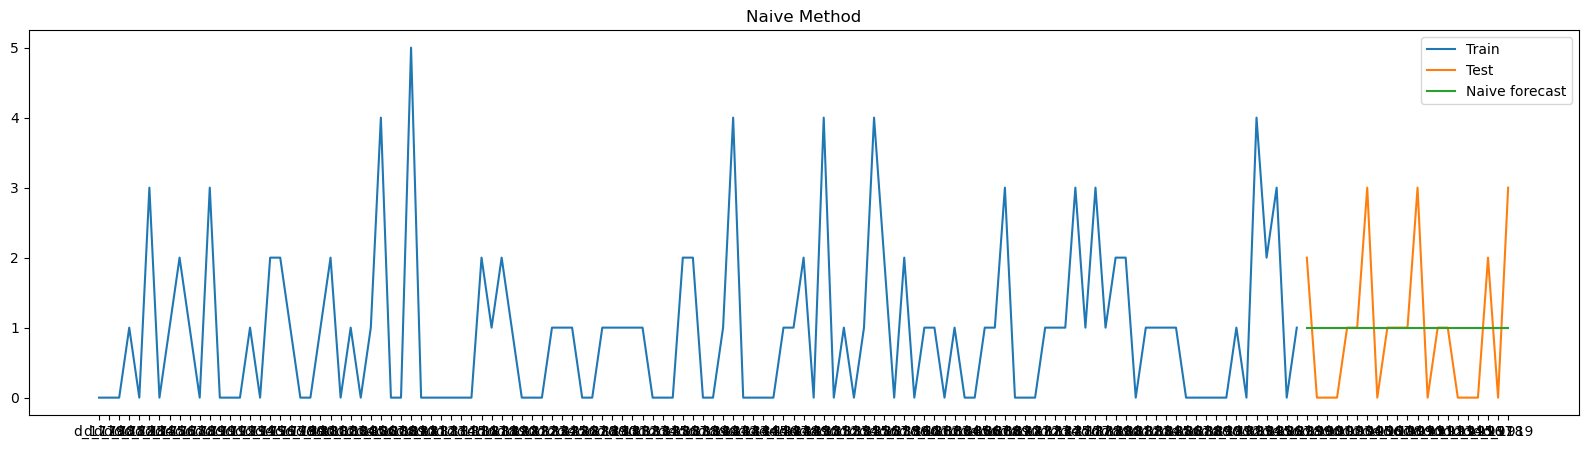

In [26]:
plt.figure(figsize=(20,5))
# plt.grid()
plt.plot(train_first_row_actual, label='Train')
plt.plot(test_first_row_actual, label='Test')
plt.plot(naive_first_row_actual['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

Then, we calculate RMSE - an error measurement - for this first row data of Naive model. Error measures are essential in demand forecasting as they provide a quantitative assessment of the accuracy of the model, which is crucial for making informed decisions and improving business outcomes. Root Mean Squared Error (RMSE) is a popular error metric that measures the square root of the average of the squared differences between the forecasted values and the actual values, taking into account both the magnitude and direction of the errors. It is quite sensitive to outliers.

In [27]:
naive_first_row_actual_rmse = np.sqrt(mean_squared_error(test_first_row_actual, naive_first_row_actual['naive_forecast'])).round(2)
naive_first_row_actual_rmse

1.05

Now, we're applying this to all rows of the data, not just the first one. We check the RMSE for every row, and calculate the mean RMSE for all the data. We also store this in a dataframe for comparsion later.

In [28]:
naive_method = sample_submission.copy()
naive_method['rmse'] = -1

# for i in range(len(naive_method_res)):
for i in range(len(naive_method)):
    row_data = train.iloc[i]
    train_row_data = row_data[1784:1904]
    test_row_data = row_data[1904:]
    naive_row_data = train_row_data[-1]
    naive_method.iloc[i, 1:22] = naive_row_data
    rmse_row_data = np.sqrt(mean_squared_error(test_row_data, naive_method.iloc[i, 1:22])).round(2)
    naive_method.iloc[i, [22]] = rmse_row_data    
    
naive_rmse = naive_method['rmse'].mean()
naive_rmse

1.803913414234175

Let's repeat this process for different kionds of error measurements. These include MAE and MAPE.

Mean Absolute Error (MAE) is a commonly used error metric for forecasting that measures the average absolute difference between the forecasted values and the actual values, without considering their direction or sign.

Mean Absolute Percentage Error (MAPE) is a commonly used error metric for forecasting that measures the average percentage difference between the forecasted values and the actual values, which is useful when the scale of the variable being forecasted is important.

In [29]:
naive_method['mae'] = -1
naive_method['mape'] = -1

# for i in range(len(naive_method_res)):
for i in range(len(naive_method)):
    row_data = train.iloc[i]
    train_row_data = row_data[1784:1904]
    test_row_data = row_data[1904:]
    naive_row_data = train_row_data[-1]
    naive_method.iloc[i, 1:22] = naive_row_data
    mae_row_data = mean_absolute_error(test_row_data, naive_method.iloc[i, 1:22]).round(2)
    mape_row_data = mean_absolute_percentage_error(test_row_data, naive_method.iloc[i, 1:22]).round(2)
    naive_method.iloc[i, [23]] = mae_row_data
    naive_method.iloc[i, [24]] = mape_row_data    

naive_mae = naive_method['mae'].mean()
naive_mape = naive_method['mape'].mean()

In [30]:
error_results = pd.DataFrame({'Method':['Naive Method', 'Average Method'], 'RMSE': [naive_rmse, "not calculated yet"], 'MAE': [naive_mae, "not calculated yet"], 'MAPE': [naive_mape, "not calculated yet"]})
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,not calculated yet,not calculated yet,not calculated yet


### Averaging

Averaging forecasting is a simple statistical algorithm that involves creating a forecast by taking the average of historical data points. It is useful for short-term and long-term forecasting of time series data that have relatively stable and consistent patterns over time, and when data is scarce. However, the simplicity of the algorithm has limitations, such as a lack of accuracy for complex or rapidly changing data, and the inability to capture trend and seasonality components of the time series. Despite these limitations, averaging forecasting can be a quick and easy method for generating a baseline forecast that can be used as a benchmark for more sophisticated models.

The average model states that we take the average of the train data set and use that as our forecasted value. First, we want to check for the RMSE of our model. To do so, we do a train-test split, where we take the last 21 days of our `train` data as our test set and take the last 120 days before the last 21 days as our train set.

Per usual, we check for the first row of our data first for visualization and to check if the model works.

In [31]:
# Try first row of the data
first_row_data_avg = train.iloc[0]
train_first_row_avg = first_row_data_avg[1784:1904]
test_first_row_avg = first_row_data_avg[1904:]
average_first_row = test_first_row_avg.copy()
average_first_row = average_first_row.to_frame()
average_first_row['average_forecast'] = train_first_row_avg.mean()

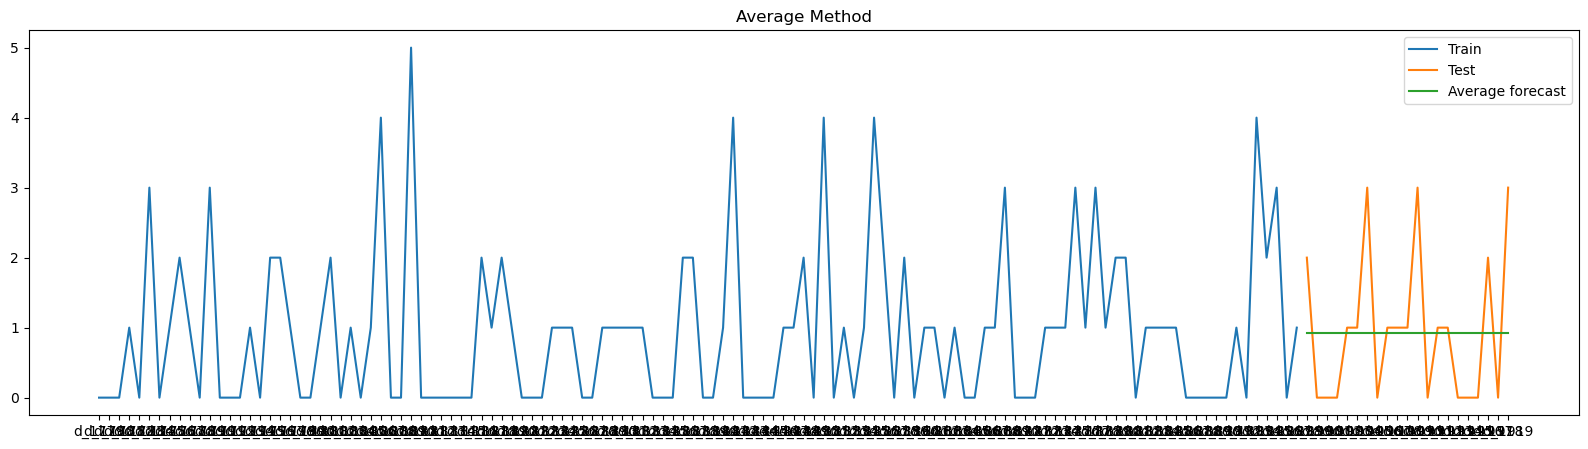

In [32]:
plt.figure(figsize=(20,5))
# plt.grid()
plt.plot(train_first_row_avg, label='Train')
plt.plot(test_first_row_avg, label='Test')
plt.plot(average_first_row['average_forecast'], label='Average forecast')
plt.legend(loc='best')
plt.title('Average Method')
plt.show()

In [33]:
average_first_row_rmse = np.sqrt(mean_squared_error(test_first_row_avg, average_first_row['average_forecast'] )).round(2)
average_first_row_rmse

1.05

Let's compute the error scores for our train-test split and see if it works better than naive.

In [34]:
average_method = sample_submission.copy()
average_method['rmse'] = -1
average_method['mae'] = -1
average_method['mape'] = -1

# for i in range(len(naive_method_res)):
for i in range(len(average_method)):
    row_data = train.iloc[i]
    train_row_data = row_data[1784:1904]
    test_row_data = row_data[1904:]
    average_row_data = train_row_data.mean()
    average_method.iloc[i, 1:22] = average_row_data
    rmse_row_data = np.sqrt(mean_squared_error(test_row_data, average_method.iloc[i, 1:22])).round(2)
    mae_row_data = mean_absolute_error(test_row_data, average_method.iloc[i, 1:22]).round(2)
    mape_row_data = mean_absolute_percentage_error(test_row_data, average_method.iloc[i, 1:22]).round(2)
    average_method.iloc[i, [22]] = rmse_row_data   
    average_method.iloc[i, [23]] = mae_row_data
    average_method.iloc[i, [24]] = mape_row_data

average_rmse = average_method['rmse'].mean()
average_mae = average_method['mae'].mean()
average_mape = average_method['mape'].mean()

In [35]:
error_results.iloc[1, [1]] = average_rmse
error_results.iloc[1, [2]] = average_mae
error_results.iloc[1, [3]] = average_mape
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75


Now that we know the average model works, we want to apply to this to all rows of the data, not just the first one. We calculate the error scores for each row, and we calculate the mean error scores for all data rows.

As you can see from the result above, the RMSE for the average model is better than the RMSE for the naive model!

Now that we have calculated our RMSE with train-test split, we want to use the model to actually predict the demand for the next 21 days after our `train` data! As before, we take the average of the last 120 days of our `train` data as our average model. 

In [62]:
average_method_res = sample_submission.copy()

for i in range(len(average_method)):
    row_data = train.iloc[i]
    train_row_data = row_data[1804:]
    average_row_data = train_row_data.mean()
    average_method_res.iloc[i, 1:22] = average_row_data

In [63]:
average_method_res.to_csv('average_method_res.csv', index=False)

Now that we have taken the average of the last 120 days of our `train` data as our average model, we wanna try what the result would be if we take the average of all of our `train` data as our average model. We assume that the former model will do better than the latter, simply because the 120 days would be a better reflection of current demand than the entirety of `train` data, which consists of 5 years of data.

In [64]:
average_method_all = sample_submission.copy()

for i in range(len(average_method_all)):
    row_data = train.iloc[i]
    train_row_data = row_data[6:1904]
    average_row_data = train_row_data.mean()
    average_method_all.iloc[i, 1:22] = average_row_data

In [65]:
average_method_all.to_csv('average_method_all.csv', index=False)

Now, we want to run a prediction in which the average only takes the last week before the prediction dates.

In [66]:
last_week = train[["id","d_1913" ,"d_1914" ,"d_1915" ,"d_1916" , "d_1917" ,"d_1918", "d_1919"]]
last_week2 = last_week.merge(last_week, on ="id")
last_week3 = last_week2.merge(last_week, on ="id")
last_week3.columns = sample_submission.columns
last_week3.to_csv("data/jon_submission7.csv", index = False)

In [67]:
last_3weeks = train.iloc[:,-21:]
last_3weeks["id"] = train["id"]
last_3weeks.insert(0, 'id', last_3weeks.pop('id'))
last_3weeks.columns = sample_submission.columns
last_3weeks.to_csv("data/jon_submission8.csv", index = False)

In [77]:
last_3weeks_avg = last_3weeks.copy()
average_last3weeks = last_3weeks.mean(axis = 1)
for i in range(len(last_3weeks_avg.columns)-1):
    last_3weeks_avg.iloc[:,i+1] = average_last3weeks
last_3weeks_avg.to_csv("data/jon_submission9.csv", index = False)

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_44972/2361099049.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_last3weeks = last_3weeks.mean(axis = 1)


In [83]:
last_week3_avg = last_week3.copy()
average_lastweek = last_week.mean(axis = 1)
for i in range(len(last_week3_avg.columns)-1):
    last_week3_avg.iloc[:,i+1] = average_lastweek
last_week3_avg.to_csv("data/jon_submission10.csv", index = False)

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_44819/3213445991.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_lastweek = last_week.mean(axis = 1)


### Seasonal Naive

This model is an extension of the naive model, but the forecast is equal to the most recent observed value in the same season. It's important for us to check seasonality, and hence we come up with the following methods.

First, since we're predicting 1 - 21 May 2016, for seasonal naive, we take 1 - 21 May 2015 (last year). Per usual, we first calculate the RMSE with train test split by using the January to April 2015 data as our train set and 1 - 21 May 2015 as our test set.

In [36]:
calendar[calendar['date'] == '2014-05-01']['d']

1188    d_1189
Name: d, dtype: object

In [37]:
seasonal_method_rmse = sample_submission.copy()
seasonal_method_rmse['rmse'] = -1
seasonal_method_rmse['mae'] = -1
seasonal_method_rmse['mape'] = -1

for i in range(len(seasonal_method_rmse)):
    row_data = train.iloc[i]
    train_row_data = row_data[1559-120:1559]
    test_row_data = row_data[1559:1559+21]
    seasonal_row_data = row_data[1194:1194+21]
    seasonal_method_rmse.iloc[i, 1:22] = seasonal_row_data
    rmse_row_data = np.sqrt(mean_squared_error(test_row_data, seasonal_method_rmse.iloc[i, 1:22])).round(2)
    mae_row_data = mean_absolute_error(test_row_data, seasonal_method_rmse.iloc[i, 1:22]).round(2)
    mape_row_data = mean_absolute_percentage_error(test_row_data, seasonal_method_rmse.iloc[i, 1:22]).round(2)
    seasonal_method_rmse.iloc[i, [22]] = rmse_row_data  
    seasonal_method_rmse.iloc[i, [23]] = mae_row_data
    seasonal_method_rmse.iloc[i, [24]] = mape_row_data 

seasonal_rmse = seasonal_method_rmse['rmse'].mean()
seasonal_mae = seasonal_method_rmse['mae'].mean()
seasonal_mape = seasonal_method_rmse['mape'].mean()

In [38]:
seasonal_row = {'Method':'Seasonal Naive', 'RMSE': seasonal_rmse, 'MAE': seasonal_mae, 'MAPE': seasonal_mape}

error_results = pd.concat([error_results, pd.DataFrame([seasonal_row])], ignore_index=True)
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75
2,Seasonal Naive,1.876678,1.335059,1702630612063785.75


Then, we use this model (last year's 1 - 21 May 2015) to predict the 1 - 21 May 2016. 

In [71]:
seasonal = sample_submission.copy()

for i in range(len(seasonal)):
    train_row_data = train.iloc[i, 1559: 1559+21]
    seasonal.iloc[i, 1:22] = train_row_data

In [72]:
seasonal.to_csv('seasonal.csv', index=False)

We want to see how this looks like visually by checking for the result of the first row of our data!

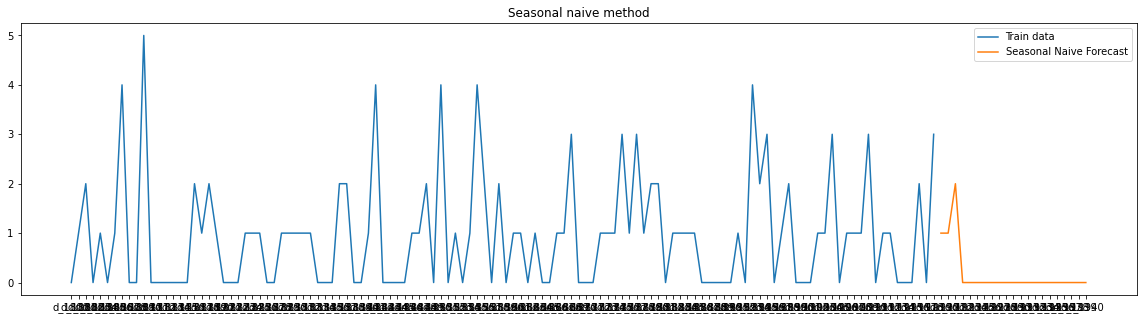

In [73]:
plt.figure(figsize=(20,5))
plt.plot(train.iloc[0, 1925-120:1925], label = 'Train data')
plt.plot(seasonal.iloc[0, 1:], label = 'Seasonal Naive Forecast')
plt.legend(loc = 'best')
plt.title('Seasonal naive method')
plt.show()

A second approach to this is by checking for seasonality in the past year for some of the data. It looks like there is a certain seasonality every month from January 2016 onwards. We manually check the plot and take the 21 days from day 1845 (16 February 2016) to day 1865 (7 March 2016). We do this because the data is more recent and there is seasonality according to some of the plots.

Let's predict using this method and plot for one of the rows.

In [40]:
seasonal_last21_tuned = sample_submission.copy()

for i in range(len(seasonal_last21_tuned)):
    train_row_data = train.iloc[0, 1850:1850+21]
    seasonal_last21_tuned.iloc[i, 1:22] = train_row_data

In [41]:
seasonal_last21_tuned.to_csv('seasonal_last21_tuned.csv', index=False)

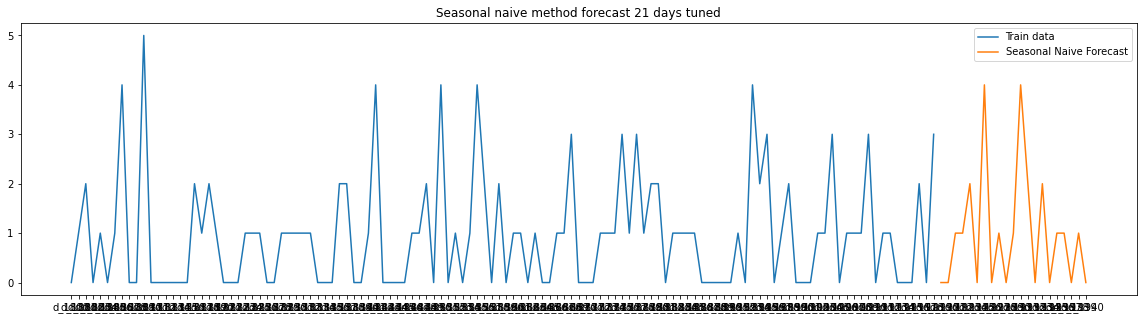

In [76]:
plt.figure(figsize=(20,5))
plt.plot(train.iloc[0, 1925-120:1925], label = 'Train data')
plt.plot(seasonal_last21_tuned.iloc[0, 1:], label = 'Seasonal Naive Forecast')
plt.legend(loc = 'best')
plt.title('Seasonal naive method forecast 21 days tuned')
plt.show()

While it might look like the model is doing better, when we predict this on Kaggle, it gives a very bad score/result. 

Third, we tried to take the last 21 days of our `train` data for predicting 1 - 21 May 2016. We ended up doing this method because it seems like there is seasonality every 21 days (like we have mentioned), including the last 21 days of our `train` data. 

We predict 1 - 21 May 2016 using this method, visualize it for one of the plots.

In [42]:
seasonal_last21 = sample_submission.copy()

for i in range(len(seasonal_last21)):
    train_row_data = train.iloc[i, 1925-21:1925]
    seasonal_last21.iloc[i, 1:22] = train_row_data

In [43]:
seasonal_last21.to_csv('seasonal_last21.csv', index=False)

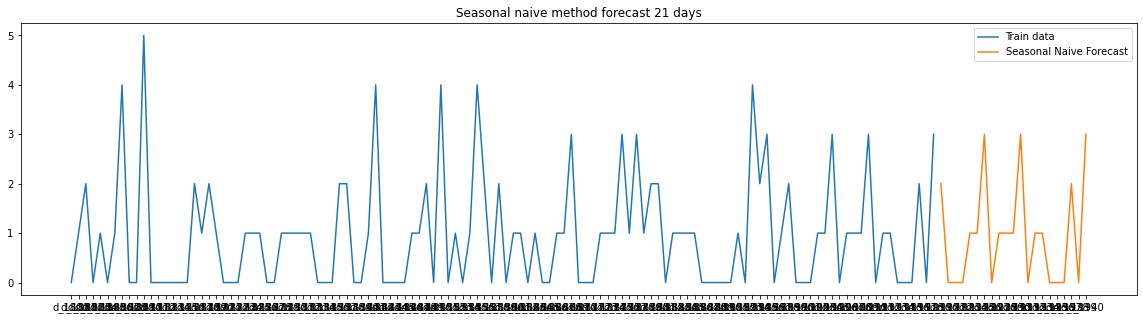

In [79]:
plt.figure(figsize=(20,5))
plt.plot(train.iloc[0, 1925-120:1925], label = 'Train data')
plt.plot(seasonal_last21.iloc[0, 1:], label = 'Seasonal Naive Forecast')
plt.legend(loc = 'best')
plt.title('Seasonal naive method forecast 21 days')
plt.show()

We also do train-test split to check  RMSE for this method. 

In [44]:
seasonal_method_last21_rmse = sample_submission.copy()
seasonal_method_last21_rmse['rmse'] = -1
seasonal_method_last21_rmse['mae'] = -1
seasonal_method_last21_rmse['mape'] = -1

for i in range(len(seasonal_method_last21_rmse)):
    row_data = train.iloc[i]
    train_row_data = row_data[1925-21-120:1925-21]
    test_row_data = row_data[1925-21:1925]
    seasonal_row_data = row_data[1925-(2*21):1925-21]
    seasonal_method_last21_rmse.iloc[i, 1:22] = seasonal_row_data
    rmse_row_data = np.sqrt(mean_squared_error(test_row_data, seasonal_method_last21_rmse.iloc[i, 1:22])).round(2)
    mae_row_data = mean_absolute_error(test_row_data, seasonal_method_last21_rmse.iloc[i, 1:22]).round(2)
    mape_row_data = mean_absolute_percentage_error(test_row_data, seasonal_method_last21_rmse.iloc[i, 1:22]).round(2)
    seasonal_method_last21_rmse.iloc[i, [22]] = rmse_row_data   
    seasonal_method_last21_rmse.iloc[i, [23]] = mae_row_data
    seasonal_method_last21_rmse.iloc[i, [24]] = mape_row_data

seasonal_last21_rmse = seasonal_method_last21_rmse['rmse'].mean()
seasonal_last21_mae = seasonal_method_last21_rmse['mae'].mean()
seasonal_last21_mape = seasonal_method_last21_rmse['mape'].mean()
seasonal_last21_rmse

1.7761265988848804

In [45]:
seasonal_last21_row = {'Method':'Seasonal Naive Last 21', 'RMSE': seasonal_last21_rmse, 'MAE': seasonal_last21_mae, 'MAPE': seasonal_last21_mape}

error_results = pd.concat([error_results, pd.DataFrame([seasonal_last21_row])], ignore_index=True)
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75
2,Seasonal Naive,1.876678,1.335059,1702630612063785.75
3,Seasonal Naive Last 21,1.776127,1.244825,1417667805674043.0


#### Drift

The drift model forecasting esesentialy is prediction going linearly increase or decrease through time as a function of time step, h, that is scaled by average historical trend.

For the drift method, we also use the last 120 days of our `train` data to predict for the next 21 days. However, before we do that, we want to check for the RMSE by doing train-test split.

In [46]:
drift_method_rmse = sample_submission.copy()
drift_method_rmse['rmse'] = -1
drift_method_rmse['mae'] = -1
drift_method_rmse['mape'] = -1

for i in range(len(drift_method_rmse)):
    row_data = train.iloc[i]
    train_row_data = row_data[1784:1904]
    constant = (train_row_data.iloc[-1] - train_row_data.iloc[0])/(len(train_row_data) - 1)
    test_row_data = row_data[1904:].to_frame(name='data')
    test_row_data['h'] = range(21)
    test_row_data['drift_forecast'] = train_row_data.iloc[-1] + test_row_data['h']*constant
    drift_method_rmse.iloc[i, 1:22] = test_row_data['drift_forecast']
    rmse_row_data = np.sqrt(mean_squared_error(test_row_data['data'], drift_method_rmse.iloc[i, 1:22])).round(2)
    mae_row_data = mean_absolute_error(test_row_data['data'], drift_method_rmse.iloc[i, 1:22]).round(2)
    mape_row_data = mean_absolute_percentage_error(test_row_data['data'], drift_method_rmse.iloc[i, 1:22]).round(2)
    drift_method_rmse.iloc[i, [22]] = rmse_row_data   
    drift_method_rmse.iloc[i, [23]] = mae_row_data
    drift_method_rmse.iloc[i, [24]] = mape_row_data


drift_rmse = drift_method_rmse['rmse'].mean()
drift_mae = drift_method_rmse['mae'].mean()
drift_mape = drift_method_rmse['mape'].mean()
drift_rmse

1.8904840931452935

In [47]:
drift_row = {'Method':'Drift', 'RMSE': drift_rmse, 'MAE': drift_mae, 'MAPE': drift_mape}

error_results = pd.concat([error_results, pd.DataFrame([drift_row])], ignore_index=True)
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75
2,Seasonal Naive,1.876678,1.335059,1702630612063785.75
3,Seasonal Naive Last 21,1.776127,1.244825,1417667805674043.0
4,Drift,1.890484,1.524484,2002462633359682.0


Now that we have calculated our RMSE, let's try predicting the next 21 days and visualizing one of the rows.

In [84]:
drift_model = sample_submission.copy()

for i in range(len(seasonal)):
    row_data = train.iloc[0]
    train_row_data = row_data[1804:]
    constant = (train_row_data.iloc[-1] - train_row_data.iloc[0])/(len(train_row_data) - 1)
    test_row_data = pd.DataFrame(range(21), columns=['h'])
    test_row_data['drift_forecast'] = train_row_data.iloc[-1] + test_row_data['h']*constant
    drift_model.iloc[i, 1:22] = test_row_data['drift_forecast']

In [85]:
drift_model.to_csv('drift_model.csv', index=False)

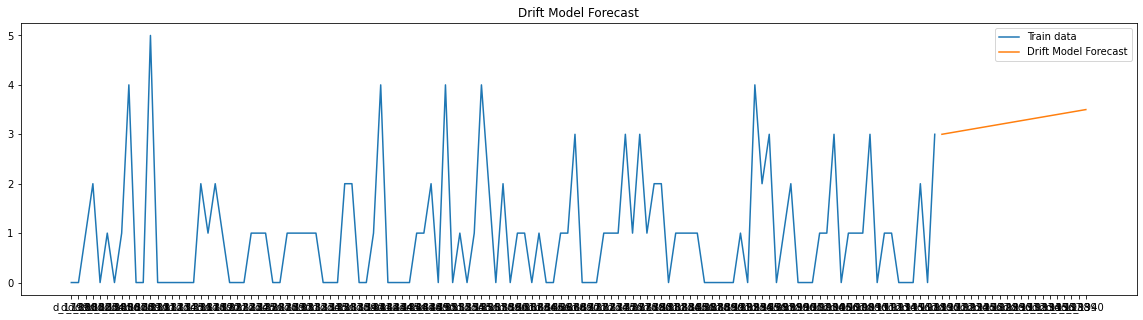

In [86]:
plt.figure(figsize=(20,5))
plt.plot(train.iloc[0, 1804:], label = 'Train data')
plt.plot(drift_model.iloc[0, 1:], label = 'Drift Model Forecast')
plt.legend(loc = 'best')
plt.title('Drift Model Forecast')
plt.show()

Another method for the drift model is by performing drift model on the last 21 days of our `train` data. We first calculate the RMSE of this model.

In [48]:
drift_last21_method_rmse = sample_submission.copy()
drift_last21_method_rmse['rmse'] = -1
drift_last21_method_rmse['mae'] = -1
drift_last21_method_rmse['mape'] = -1

for i in range(len(drift_method_rmse)):
    row_data = train.iloc[i]
    train_row_data = row_data[1904-21:1904]
    constant = (train_row_data.iloc[-1] - train_row_data.iloc[0])/(len(train_row_data) - 1)
    test_row_data = row_data[1904:].to_frame(name='data')
    test_row_data['h'] = range(21)
    test_row_data['drift_forecast'] = train_row_data.iloc[-1] + test_row_data['h']*constant
    drift_last21_method_rmse.iloc[i, 1:22] = test_row_data['drift_forecast']
    rmse_row_data = np.sqrt(mean_squared_error(test_row_data['data'], drift_last21_method_rmse.iloc[i, 1:22])).round(2)
    mae_row_data = mean_absolute_error(test_row_data['data'], drift_last21_method_rmse.iloc[i, 1:22]).round(2)
    mape_row_data = mean_absolute_percentage_error(test_row_data['data'], drift_last21_method_rmse.iloc[i, 1:22]).round(2)
    drift_last21_method_rmse.iloc[i, [22]] = rmse_row_data   
    drift_last21_method_rmse.iloc[i, [23]] = mae_row_data
    drift_last21_method_rmse.iloc[i, [24]] = mape_row_data

drift_last21_rmse = drift_last21_method_rmse['rmse'].mean()
drift_last21_mae = drift_last21_method_rmse['mae'].mean()
drift_last21_mape = drift_last21_method_rmse['mape'].mean()
drift_last21_rmse

2.3864476877664806

In [49]:
drift_last21_row = {'Method':'Drift Last 21', 'RMSE': drift_last21_rmse, 'MAE': drift_last21_mae, 'MAPE': drift_last21_mape}

error_results = pd.concat([error_results, pd.DataFrame([drift_last21_row])], ignore_index=True)
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75
2,Seasonal Naive,1.876678,1.335059,1702630612063785.75
3,Seasonal Naive Last 21,1.776127,1.244825,1417667805674043.0
4,Drift,1.890484,1.524484,2002462633359682.0
5,Drift Last 21,2.386448,2.005143,2744161791688543.5


Now, we predict the next 21 days using this model.

In [89]:
drift_model_last21 = sample_submission.copy()

for i in range(len(drift_model_last21)):
    row_data = train.iloc[0]
    train_row_data = row_data[1919-21:]
    constant = (train_row_data.iloc[-1] - train_row_data.iloc[0])/(len(train_row_data) - 1)
    test_row_data = pd.DataFrame(range(21), columns=['h'])
    test_row_data['drift_forecast'] = train_row_data.iloc[-1] + test_row_data['h']*constant
    drift_model_last21.iloc[i, 1:22] = test_row_data['drift_forecast']

In [90]:
drift_model_last21.to_csv('drift_model_last21.csv', index=False)

#### Summary of Basic models

In [50]:
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75
2,Seasonal Naive,1.876678,1.335059,1702630612063785.75
3,Seasonal Naive Last 21,1.776127,1.244825,1417667805674043.0
4,Drift,1.890484,1.524484,2002462633359682.0
5,Drift Last 21,2.386448,2.005143,2744161791688543.5


In [51]:
error_results.to_csv('error_results.csv')

As we have seen from the RMSE above, the best model for basic model is average method since it has the lowest RMSE. This is why when we submitted our results in Kaggle, the average method gives quite an impressive result! 

As an aside, the large MAPE numbers are a result of the values in our dataset being very small numbers. This means that even small errors in the predictions can lead to large percentage errors when calculating the MAPE. MAPE might not be a good error metric for our use case.

## ETS

ETS is a statistical algorithm for time series forecasting that decomposes data into error, trend, and seasonality components. It uses exponential smoothing to model each component and make predictions about future values. ETS is useful for time series with clear trends or seasonality and can be used for short- and long-term forecasting.

### Simple ETS

Let's first create a simple ETS model that only takes into account historical trends in demand:

In [144]:
train_q = train.drop(columns=['item_id','subcat_id','category_id','store_id','region_id']).set_index('id')
train_q = train_q.T
train_q

id,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,Beauty_1_010_East_1,...,Food_3_818_West_3,Food_3_819_West_3,Food_3_820_West_3,Food_3_821_West_3,Food_3_822_West_3,Food_3_823_West_3,Food_3_824_West_3,Food_3_825_West_3,Food_3_826_West_3,Food_3_827_West_3
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1915,0,1,0,0,0,0,0,3,2,2,...,4,2,2,0,2,0,1,0,3,0
d_1916,0,0,1,1,2,1,0,2,6,1,...,0,0,1,0,2,0,1,1,0,0
d_1917,2,0,1,2,3,0,0,8,0,0,...,1,0,1,3,2,2,1,1,1,0
d_1918,0,0,0,4,1,0,1,8,0,0,...,2,1,1,1,2,2,0,0,2,0


In [145]:
prices1 = price.copy()
prices1['id'] = prices1['item_id'] + '_' + prices1['store_id']
time = pd.merge(calendar, prices1, on='wm_yr_wk')
pt = pd.pivot_table(time[['id','d','sell_price']], values=['sell_price'], columns=['id'], index=['d'], fill_value=0)
pt = pt.reindex(calendar['d'])
pt

sell_price                                                \
id     Beauty_1_001_Central_1 Beauty_1_001_Central_2 Beauty_1_001_Central_3   
d                                                                             
d_1                      0.00                   0.00                   0.00   
d_2                      0.00                   0.00                   0.00   
d_3                      0.00                   0.00                   0.00   
d_4                      0.00                   0.00                   0.00   
d_5                      0.00                   0.00                   0.00   
...                       ...                    ...                    ...   
d_1965                   8.26                   8.26                   8.26   
d_1966                   8.26                   8.26                   8.26   
d_1967                   8.26                   8.26                   8.26   
d_1968                   8.26                   8.26                   8.26   
d_1969                   8.26                   8.26                   8.26   

                                                                    \
id     Beauty_1_001_East_1 Beauty_1_001_East_2 Beauty_1_001_East_3   
d                                                                    
d_1                   0.00                0.00                0.00   
d_2                   0.00                0.00                0.00   
d_3                   0.00                0.00                0.00   
d_4                   0.00                0.00                0.00   
d_5                   0.00                0.00                0.00   
...                    ...                 ...                 ...   
d_1965                8.38                8.38                8.38   
d_1966                8.38                8.38                8.38   
d_1967                8.38                8.38                8.38   
d_1968                8.38                8.38                8.38   
d_1969                8.38                8.38                8.38   

                                                                    \
id     Beauty_1_001_East_4 Beauty_1_001_West_1 Beauty_1_001_West_2   
d                                                                    
d_1                   0.00                0.00                0.00   
d_2                   0.00                0.00                0.00   
d_3                   0.00                0.00                0.00   
d_4                   0.00                0.00                0.00   
d_5                   0.00                0.00                0.00   
...                    ...                 ...                 ...   
d_1965                8.38                8.38                8.38   
d_1966                8.38                8.38                8.38   
d_1967                8.38                8.38                8.38   
d_1968                8.38                8.38                8.38   
d_1969                8.38                8.38                8.38   

                            ...                                            \
id     Beauty_1_001_West_3  ... Food_3_827_Central_1 Food_3_827_Central_2   
d                           ...                                             
d_1                   0.00  ...                    0                    0   
d_2                   0.00  ...                    0                    0   
d_3                   0.00  ...                    0                    0   
d_4                   0.00  ...                    0                    0   
d_5                   0.00  ...                    0                    0   
...                    ...  ...                  ...                  ...   
d_1965                8.38  ...                    1                    1   
d_1966                8.38  ...                    1                    1   
d_1967                8.38  ...                    1                    1   
d_1968                8.38

In [146]:
c = []
for r in np.arange(1920,1941):
    c.append('d_'+str(r))

In [161]:
# # The following code takes 30 minutes to 1 hour to run. Hence, it's commented out.

# # Make a dataframe of the timeframe we want to use
# # Select last 1092 days of revenue data
# year3 = train_q.loc["d_828":]

# # List to store ETS model predictions for each item
# s_ets3 = []

# # Train an ETS model for each item in the training dataset
# for c in year3.columns:
#     # Select last 364 days of sales data and convert to Pandas series
#     sales_data_train = pd.Series(year3[c]).astype('float64')
    
#     # Fit ETS model to sales data and generate 21-day forecast
#     model = ETSModel(sales_data_train, trend='add', seasonal='add', seasonal_periods=7)
#     fit = model.fit()
#     forecast = fit.forecast(steps=21)
#     s_ets3.append([c, forecast]) # Store item ID and forecast in s_ets list

# # Create new dataframe to store 21-day sales forecasts for each item
# cols, vals = [], []
# for r in range(len(s_ets3)):
#     cols.append(s_ets3[r][0])
#     vals.append(list(s_ets3[r][1]))

# simple_ets3 = pd.DataFrame(np.array(vals), columns=c)
# simple_ets3['id'] = cols
# simple_ets3 = simple_ets3.set_index('id')

# # Return dataframe containing 21-day sales forecasts for each item
# simple_ets3

In [162]:
# simple_ets3.to_csv('simple_ets.csv', index=False)

### ETS with last 3 years of revenue data

Let's make a more complex model that this time attempts to account for price information by using revenue data. In here, we use the last 3 years of our reveunue data.

In [163]:
# # The following code takes 30 minutes to 1 hour to run. Hence, it's commented out.

# revenue = revs.copy()
# rev = revenue.drop(columns=['date'], axis=1)

# # Make a dataframe of the timeframe we want to use
# # Select last 1092 days of revenue data
# rev_y3 = revenue.loc[828:]

# # List to store ETS model predictions for each item's revenue
# r_ets3 = []

# # Train an ETS model for each item's revenue in the revenue dataset
# for c in rev_y3.columns:
#     # Convert to Pandas series
#     sales_data_train = pd.Series(rev_y3[c]).astype('float64')
    
#     # Fit ETS model to revenue data and generate 21-day forecast
#     model = ETSModel(sales_data_train, trend='add', seasonal='add', seasonal_periods=7)
#     fit = model.fit()
#     forecast = fit.forecast(steps=21)
#     r_ets3.append([c, forecast]) # Store item ID and forecast in r_ets list

# # Create new dataframe to store 21-day revenue forecasts for each item
# cols, vals = [], []
# for r in range(len(r_ets3)):
#     cols.append(r_ets3[r][0])
#     vals.append(list(r_ets3[r][1]))

# rev_ets3 = pd.DataFrame(np.array(vals), columns=c)
# rev_ets3['id'] = cols
# rev_ets3 = rev_ets3.set_index('id')

# # Compute revenue predictions by dividing ETS revenue forecasts by item sell prices
# re3 = rev_ets3.T
# pt2 = pt.iloc[1919:1940]
# val, col = [], []
# for r in re.columns:
#     i = re3[r]/pt2[('sell_price',r)]
#     col.append(r)
#     val.append(i)
# rev_ets_preds3 = pd.DataFrame(np.array(val), columns=c)
# rev_ets_preds3['id'] = col
# rev_ets_preds3 = rev_ets_preds3.set_index('id')

# # Return dataframe containing 21-day revenue forecasts for each item
# rev_ets_preds3

In [164]:
# rev_ets_preds3.to_csv('rev_3y_ets.csv', index=False)

### Comparing error values with basic models

To compare this model with our basic models, we can use a train-test split similar to what we used to test the basic models. Unfortunately due to the computational expensiveness of ETS models (relative to the time-frame of this project), we were only able to do this for the model described above. Here we calculate the RMSE for the train-test split and add it to `error_results`:

In [52]:
rev_ets_error = pd.read_csv('Subs/rev_preds.csv')

In [53]:
rev_ets_error

,id,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,...,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918
0,Beauty_1_001_East_1,0.861125,0.724405,0.889945,0.703274,0.542153,0.784385,1.088391,0.864347,0.727627,...,0.545374,0.787607,1.091612,0.867568,0.730848,0.896388,0.709717,0.548596,0.790828,1.094833
1,Beauty_1_002_East_1,0.222604,0.125652,0.155092,0.174015,0.231095,0.251395,0.289019,0.221387,0.124434,...,0.229877,0.250177,0.287802,0.220169,0.123216,0.152656,0.171579,0.228659,0.248959,0.286584
2,Beauty_1_003_East_1,0.242956,0.137218,0.156731,0.136990,0.156713,0.214330,0.464178,0.243071,0.137332,...,0.156827,0.214445,0.464293,0.243185,0.137446,0.156959,0.137219,0.156942,0.214559,0.464407
3,Beauty_1_004_East_1,3.846494,1.281415,0.885175,0.978134,1.353023,1.556756,2.816902,3.839368,1.274290,...,1.345898,1.549630,2.809777,3.832243,1.267164,0.870924,0.963883,1.338772,1.542505,2.802651
4,Beauty_1_005_East_1,1.731837,0.953616,1.040937,0.962148,1.100538,1.100999,1.707275,1.734532,0.956311,...,1.103233,1.103694,1.709970,1.737226,0.959006,1.046327,0.967538,1.105928,1.106389,1.712665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,0.351464,0.091285,0.074569,0.278066,0.104314,0.185133,0.217596,0.353306,0.093127,...,0.106156,0.186974,0.219438,0.355148,0.094969,0.078252,0.281749,0.107997,0.188816,0.221279
30486,Food_3_824_West_3,0.085846,0.074673,0.076246,0.138198,0.024234,0.034631,0.074665,0.082852,0.071679,...,0.021240,0.031637,0.071671,0.079857,0.068685,0.070258,0.132210,0.018246,0.028643,0.068677
30487,Food_3_825_West_3,1.202395,0.940292,0.823944,0.977758,0.853775,1.037257,1.036099,1.203998,0.941894,...,0.855377,1.038860,1.037701,1.205600,0.943497,0.827149,0.980963,0.856980,1.040462,1.039304
30488,Food_3_826_West_3,1.403686,1.095326,1.103822,1.007693,0.892869,0.825218,1.065459,1.403005,1.094644,...,0.892188,0.824537,1.064778,1.402323,1.093963,1.102460,1.006330,0.891507,0.823856,1.064097


In [67]:
reference = pd.read_csv('Model Comparisons/reference.csv').drop(columns=['Unnamed: 0'])
reference

,id,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,2,0,0,0,1,1,3,0,1,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,0,0,0,1,2,2,1,2,1,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,4,2,0,3,0,1,0,5,4,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,1,2,0,1,1,2,1,1,0,...,2,2,2,4,1,0,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,0,2,0,0,0,2,0,0,0,...,1,0,0,1,0,0,0,2,2,0
30486,Food_3_824_West_3,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,0
30487,Food_3_825_West_3,2,4,0,0,0,2,1,0,2,...,0,0,1,0,0,0,1,1,0,2
30488,Food_3_826_West_3,2,0,1,0,3,0,0,1,0,...,0,3,1,3,1,3,0,1,2,1


In [133]:
# Calculate the errors for each day and product
errors = rev_ets_error.iloc[:, 2:22] - reference.iloc[:, 1:21]

# Calculate RMSE for each product
rev_ets_error['rmse'] = np.sqrt((errors**2).mean(axis=1))

# Calculate MAE for each product
rev_ets_error['mae'] = errors.abs().mean(axis=1)

# Replace zeros in the reference dataframe with a small positive number (e.g., 1e-8) to avoid division by zero
reference_no_zeros = reference.iloc[:, 1:21].replace(0, 1e-8)

# Calculate MAPE for each product
rev_ets_error['mape'] = (errors.abs() / reference_no_zeros.abs()).mean(axis=1) * 100

# Calculate overall RMSE, MAE, and MAPE
ets_rmse = np.mean(rev_ets_error['rmse'])
ets_mae = np.mean(rev_ets_error['mae'])
ets_mape = np.mean(rev_ets_error['mape'])

print("Overall RMSE:", ets_rmse)
print("Overall MAE:", ets_mae)
print("Overall MAPE:", ets_mape)


Overall RMSE: 1.326223529096763
Overall MAE: 1.0386244999409622
Overall MAPE: 3274035594.5907893


In [129]:
ets_row = {'Method':'ETS (3y revenue)', 'RMSE': ets_rmse, 'MAE': ets_mae, 'MAPE': ets_mape}

error_results = pd.concat([error_results, pd.DataFrame([ets_row])], ignore_index=True)
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75
2,Seasonal Naive,1.876678,1.335059,1702630612063785.75
3,Seasonal Naive Last 21,1.776127,1.244825,1417667805674043.0
4,Drift,1.890484,1.524484,2002462633359682.0
5,Drift Last 21,2.386448,2.005143,2744161791688543.5
6,ETS (3y revenue),1.326224,1.038624,3274035594.590789


### ETS with last 2 years of revenue data

Now, let's create this model that accounts the last 2 years of our revenue data.

In [165]:
# # The following code takes 30 minutes to 1 hour to run. Hence, it's commented out.

# # ETS for 2 years
# rev = revenue.drop(columns=['date'], axis=1)

# # Make a dataframe of the timeframe we want to use
# # Select last 728 days of revenue data
# rev_y2 = revenue.loc[1191:]

# # List to store ETS model predictions for each item's revenue
# r_ets2 = []

# # Train an ETS model for each item's revenue in the revenue dataset
# for c in rev_y2.columns:
#     # Convert to Pandas series
#     sales_data_train = pd.Series(rev_y2[c]).astype('float64')
    
#     # Fit ETS model to revenue data and generate 21-day forecast
#     model = ETSModel(sales_data_train, trend='add', seasonal='add', seasonal_periods=7)
#     fit = model.fit()
#     forecast = fit.forecast(steps=21)
#     r_ets2.append([c, forecast]) # Store item ID and forecast in r_ets list

# # Create new dataframe to store 21-day revenue forecasts for each item
# cols, vals = [], []
# for r in range(len(r_ets2)):
#     cols.append(r_ets2[r][0])
#     vals.append(list(r_ets2[r][1]))

# rev_ets2 = pd.DataFrame(np.array(vals), columns=c)
# rev_ets2['id'] = cols
# rev_ets2 = rev_ets2.set_index('id')

# # Compute revenue predictions by dividing ETS revenue forecasts by item sell prices
# re2 = rev_ets2.T
# pt2 = pt.iloc[1919:1940]
# val, col = [], []
# for r in re.columns:
#     i = re2[r]/pt2[('sell_price',r)]
#     col.append(r)
#     val.append(i)
# rev_ets_preds2 = pd.DataFrame(np.array(val), columns=c)
# rev_ets_preds2['id'] = col
# rev_ets_preds2 = rev_ets_preds2.set_index('id')

# # Return dataframe containing 21-day revenue forecasts for each item
# rev_ets_preds2

In [166]:
# rev_ets_preds2.to_csv('rev_2y_ets.csv', index=False)

### ETS with last 1 year of revenue data

Now, let's create this model that accounts the last year of our revenue data.

In [167]:
# # The following code takes 30 minutes to 1 hour to run. Hence, it's commented out.

# # ETS for 1 year
# rev = revenue.drop(columns=['date'], axis=1)

# # Make a dataframe of the timeframe we want to use
# # Select last 364 days of revenue data
# rev_y1 = revenue.loc[1555:]

# # List to store ETS model predictions for each item's revenue
# r_ets1 = []

# # Train an ETS model for each item's revenue in the revenue dataset
# for c in rev_y1.columns:
#     # Convert to Pandas series
#     sales_data_train = pd.Series(rev_y1[c]).astype('float64')
    
#     # Fit ETS model to revenue data and generate 21-day forecast
#     model = ETSModel(sales_data_train, trend='add', seasonal='add', seasonal_periods=7)
#     fit = model.fit()
#     forecast = fit.forecast(steps=21)
#     r_ets1.append([c, forecast]) # Store item ID and forecast in r_ets list

# # Create new dataframe to store 21-day revenue forecasts for each item
# cols, vals = [], []
# for r in range(len(r_ets1)):
#     cols.append(r_ets1[r][0])
#     vals.append(list(r_ets1[r][1]))

# rev_ets1 = pd.DataFrame(np.array(vals), columns=c)
# rev_ets1['id'] = cols
# rev_ets1 = rev_ets1.set_index('id')

# # Compute revenue predictions by dividing ETS revenue forecasts by item sell prices
# re1 = rev_ets1.T
# pt2 = pt.iloc[1919:1940]
# val, col = [], []
# for r in re.columns:
#     i = re1[r]/pt2[('sell_price',r)]
#     col.append(r)
#     val.append(i)
# rev_ets_preds1 = pd.DataFrame(np.array(val), columns=c)
# rev_ets_preds1['id'] = col
# rev_ets_preds1 = rev_ets_preds1.set_index('id')

# # Return dataframe containing 21-day revenue forecasts for each item
# rev_ets_preds1

In [168]:
# rev_ets_preds1.to_csv('rev_ets.csv', index=False)

## ARIMA (pmdarima)

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model commonly used for time series forecasting. It captures the autocorrelation and stationarity in the data by fitting a linear combination of past observations. The model requires the data to be stationary, which means that its statistical properties such as mean and variance do not change over time. ARIMA models are flexible and can handle a wide range of time series patterns, making them useful for forecasting various business and economic phenomena.

In [169]:
# Creating a wide dataset for the sales data with each column being a product to make it easier to loop over when training per column

# Adding date
orig = train2.join(price3['date']).drop('d', axis=1).set_index('date')

# Converting the index to datetime
orig.index = pd.to_datetime(orig.index, format='%Y-%m-%d')

### Inspection and Stationarity/Seasonality checking

We analyse the data on a total sales per day level because it's not feasible to check by hand each of the products. Assuming all products share some underlying factors, as we saw in the EDA, this is a workable approach to get the gist of the data.

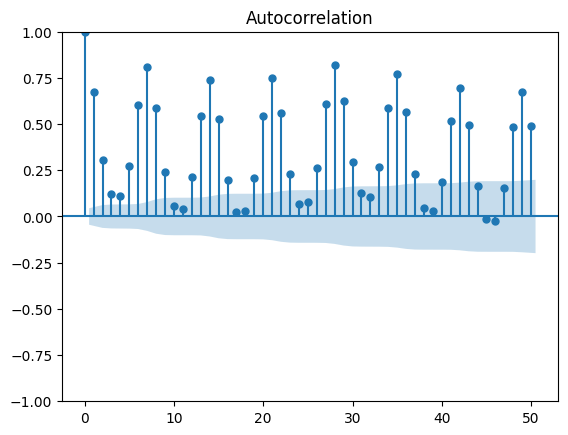

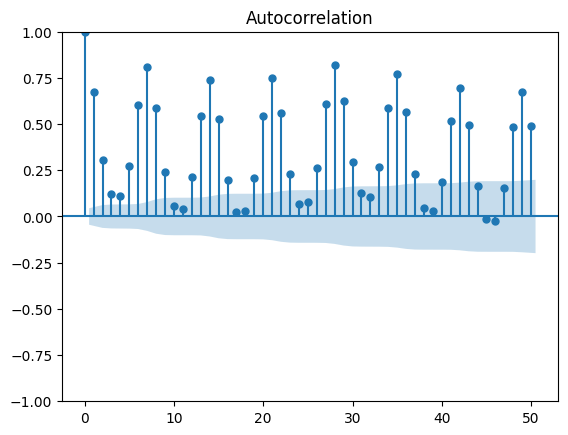

In [ ]:
plot_acf(daily_sales, lags=50)

The data is obviously not stationary and has what looks to be an m=7 (weekly) seasonality as evidenced by the sinusoidal pattern.

d found via ch-test: 1
D found via ch-test: 1


C:\Users\seanm\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


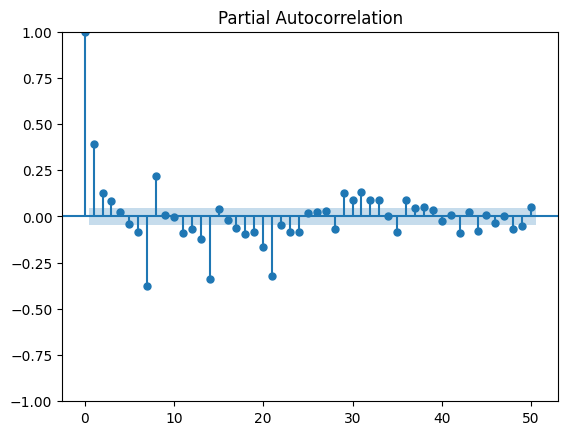

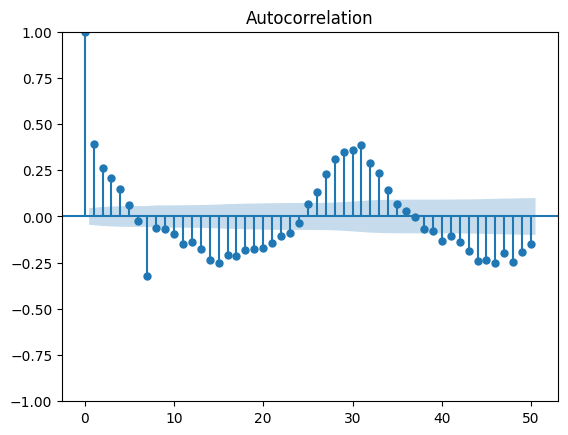

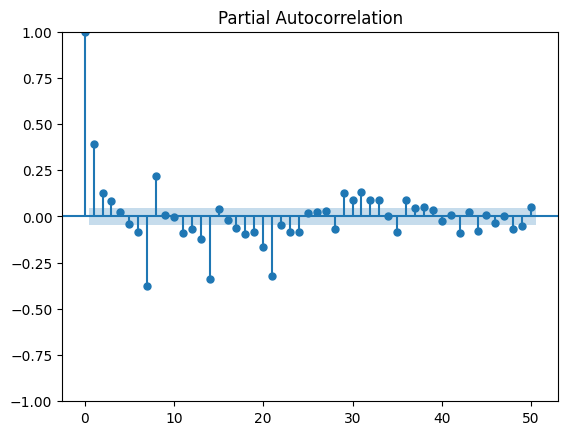

In [ ]:
# performing stationarity test and finding appropriate d.
d = pmdarima.arima.utils.ndiffs(daily_sales, test='kpss')
print(f"d found via ch-test: {d}")

# performing seasonal stationarity test and finding appropriate D.
D = pmdarima.arima.utils.nsdiffs(daily_sales, m=7, test='ch')
print(f"D found via ch-test: {d}")

# performing D seasonal differencing first. Dropping the first 7 observations since they will be empty
daily_sales_D_1 = daily_sales.diff(periods=7).dropna()

# plotting acf and pacf for seasonally differenced data
plot_acf(daily_sales_D_1, lags=50)
plot_pacf(daily_sales_D_1, lags=50)

There looks to be still a pattern in the ACF graph. We can attempt an additional d=1 differencing on-top of the seasonality differencing.

d found via ch-test after seasonally differencing: 0


C:\Users\seanm\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


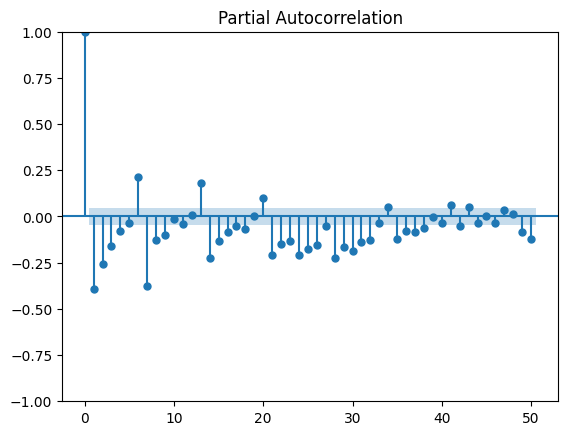

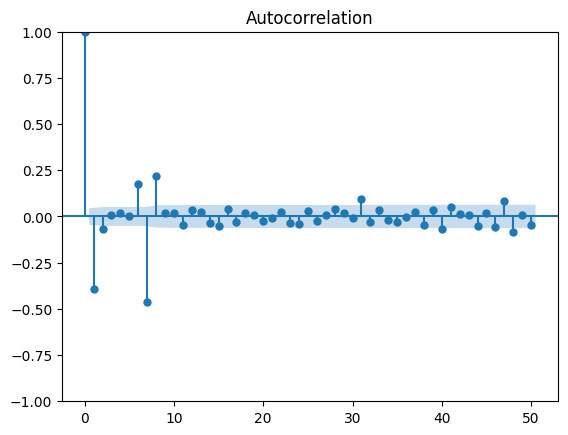

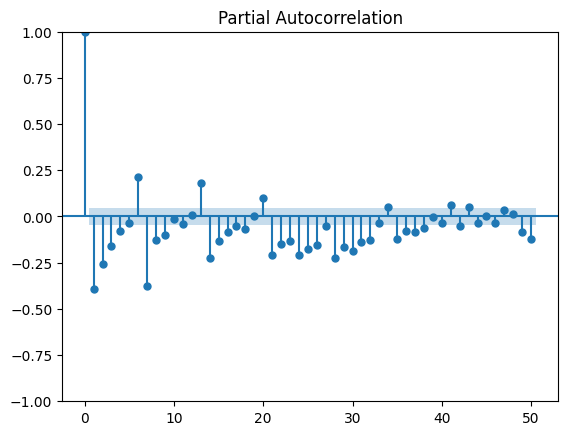

In [ ]:
# retesting for stationarity.
d2 = pmdarima.arima.utils.ndiffs(daily_sales_D_1, test='kpss')
print(f"d found via ch-test after seasonally differencing: {d2}")

# performing regular differencing with d=1
daily_sales_D_1_d_1 = daily_sales_D_1.diff().dropna()

# plotting acf and pacf for D=1, d=1 data
plot_acf(daily_sales_D_1_d_1, lags=50)
plot_pacf(daily_sales_D_1_d_1, lags=50)

With seasonality D=1 with a period of m=7 (weekly) followed by a regular differencing d=1 the ACF and PACF look sufficiently stationary. Since there is a cost to futher differencing this is an appropriate place to stop.

### Finding ARIMA order

Informed by our visual inspection before, we perform and autoarima search for d=1, D=1, and the p, P, q, Q, between 0-7 jugding by the spikes in the ACF and PACF, with a likely value <3. 
We could tune it by hand, but an auto search would be able to capture mixed p/P, q/Q > 1 models better than what can be interpreted from the graphs.

In [ ]:
m1 = auto_arima(daily_sales, seasonal=True, max_p=7, max_q=7, max_P_=7, max_Q=7, m=7, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, out_of_sample_size=21)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=37935.677, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=37250.504, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=37628.807, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=36994.717, Time=2.22 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.62 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=37280.052, Time=0.66 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=36871.948, Time=2.52 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=37122.753, Time=0.68 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=6.50 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.20 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=36930.803, Time=1.54 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=36916.821, Ti

Code output replicated here, model is time consuming so was not re-run for the purpose of this consolidated workbook.

Performing stepwise search to minimize aic  
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=3.70 sec  
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=37935.689, Time=0.04 sec  
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=37247.636, Time=0.25 sec  
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.90 sec  
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=37628.793, Time=0.09 sec  
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=36994.665, Time=1.76 sec  
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.94 sec  
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.97 sec  
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=37280.027, Time=0.32 sec  
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=36871.900, Time=1.92 sec  
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=37119.930, Time=0.35 sec  
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.39 sec  
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.19 sec  
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=36927.177, Time=0.84 sec  
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=36913.087, Time=1.29 sec  
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=36911.350, Time=1.00 sec  
 ARIMA(3,1,1)(2,1,0)[7]             : AIC=inf, Time=6.15 sec
 ARIMA(2,1,0)(2,1,0)[7] intercept   : AIC=36873.855, Time=2.22 sec  

Best model:  **ARIMA(2,1,0)(2,1,0)[7]**            
Total fit time: 30.336 seconds  

**The serach found an ARIMA(2,1,0)(2,1,0)[7] optimising based on AIC.**  Now we fit the model and assess it.

In [ ]:
# We use the last 21 days as the test set
test = pd.DataFrame({'values': daily_sales[-21:]})

# This function gets the predictions for the test set and plots the actual vs prediction and the diagnostics. Each item's data is clipped to remove any leading zero values,
# i.e. when the item is yet to exist.
def auto_arima_diagnostic(model, df):
    prediction, confint = model.predict(n_periods=21, return_conf_int=True)
    rmse = mean_squared_error(test, prediction, squared=False)
    print(f"RMSE: {rmse}.")
    cf= pd.DataFrame(confint)
    prediction_series = pd.Series(prediction, index=test.index)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(df.index[-90:], df.values[-90:])
    ax.plot(prediction_series, color='red', alpha=.8)
    ax.fill_between(prediction_series.index,
                    cf[0],
                    cf[1],color='grey',alpha=.3)
    model.plot_diagnostics(figsize=(14,10))
    plt.show()

RMSE: 1318.8441203283214.


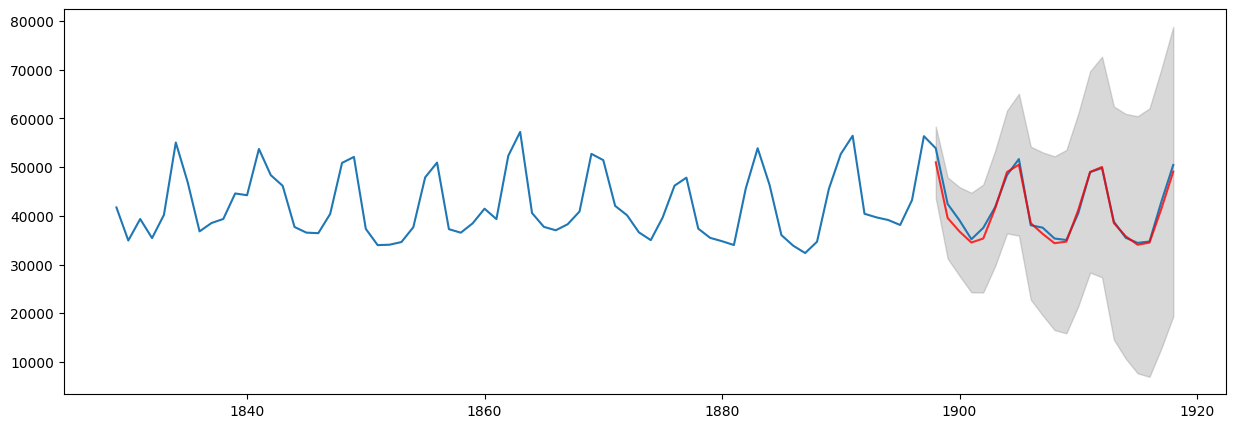

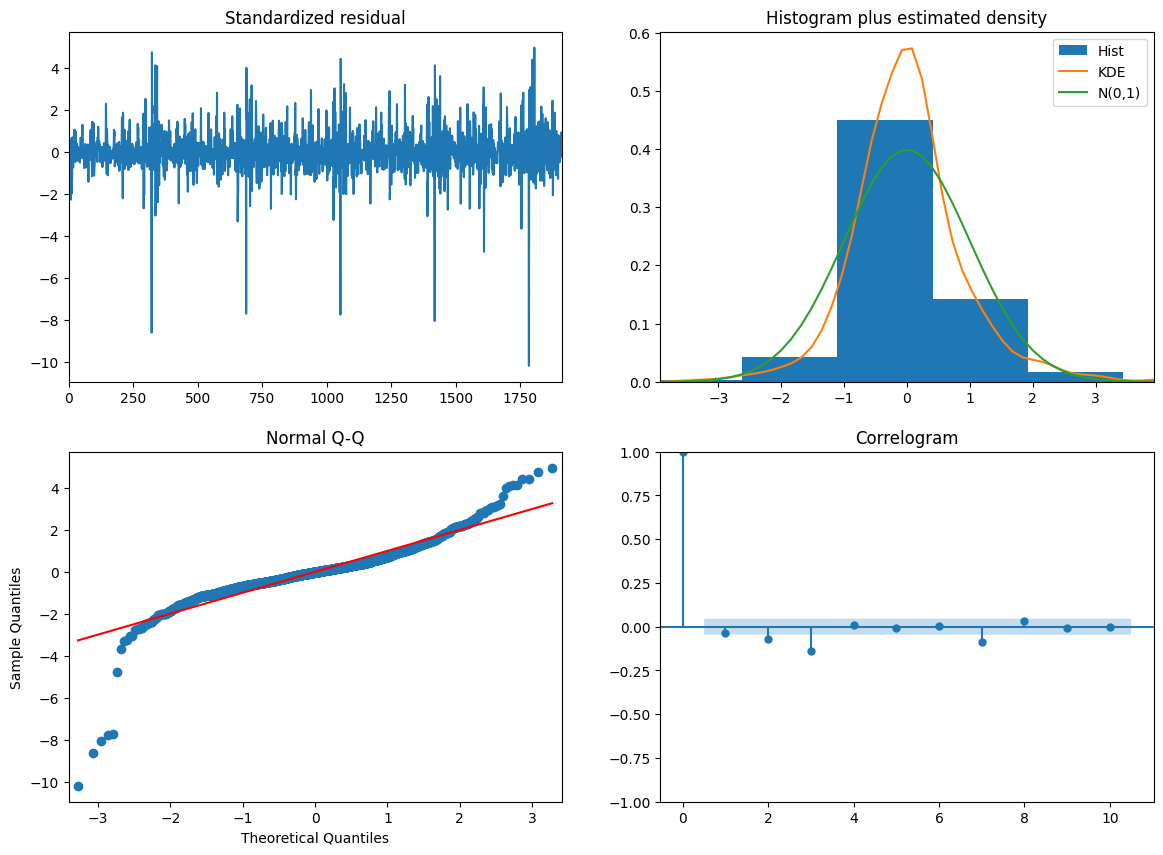

In [ ]:
auto_arima_diagnostic(m1, daily_sales)

We can see that the model is very accurate at modelling the total sales with an RMSE of only 1318.

In [ ]:
# These are the parameters for model.
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1919
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -18430.974
Date:                           Tue, 25 Apr 2023   AIC                          36871.948
Time:                                   14:24:22   BIC                          36899.725
Sample:                                        0   HQIC                         36882.171
                                          - 1919                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.010    -44.868      0.000      -0.487      -0.446
ar.L2         -0.2507      0.016    -15.346      0.000      -0.283      -0.219
ar.S.L7       -0.5908      0.013    -43.933      0.000      -0.617      -0.564
ar.S.L14      -0.3171      0.011    -29.311      0.000      -0.338      -0.296
sigma2      1.404e+07   1.62e+05     86.746      0.000    1.37e+07    1.44e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.58   Jarque-Bera (JB):             21019.26
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training per item

After finding appropriate parameters by the running the auto_arima on the total sales pey day level, we train individual models per item with those parameters.

In [ ]:
# This function takes ARIMA parameters and fits a model per item, collects the predictions for the forward 21 days, and returns predictions in the sample submission format.
# Multiprocessing is used to fit x=no. of cpu cores models at a time.

def auto_arima_column_mp(col, **kwargs):
    from pmdarima import ARIMA
    # print(col)
    first_day_of_sales = (col != 0).idxmax()
    cropped_data = col.loc[first_day_of_sales:]
    model_spec = ARIMA(**kwargs)
    pred = model_spec.fit_predict(cropped_data.values, X=None, n_periods=21)
    # print(col)
    return pred

def auto_arima_all_column_pb_md(df, sample, start=0, end=30490, **kwargs): #start and end at the indices of the columns to be predicted
    import multiprocesspandas
    df= df.loc[:, df.columns[start:end]]
    pred = df.apply_parallel(auto_arima_column_mp, axis = 1, num_processors=4, **kwargs)
    # print(pred)
    for i in range(start,end):
        sample.iloc[i,1:] = pred[i]
    return sample

Unfortunately we found that it was too computationally expensive to train the intended model on a per item level. Even on the NUS supercomputer, we could not get enough walltime to finish the calcuation. Even when it did compute successfully we saw training errors leading to incredibly large or small values.

In [ ]:
# Uncomment to run.
# m1 = auto_arima_all_column_pb_md(orig, sample, start=0, end=30490, order = (2,1,0), seasonal_order=(2, 1, 0, 7), suppress_warnings=False, scoring='mse', scoring_args=None, with_intercept=False)

We performed a combination of runtime tests, varying the solving methods, orders, max iterations, and different levels of data cropping (i.e. taking the most recent 90 days instead of the whole data). We found that it was **impractical to run the seaonal model**, this is because the seasonal period essentially multiplicatively increases the number of terms in the model.

Although we theoretically know that a sesaonal model should perform better, compute contraints mean we have to search for a simple non-seasonal model.

Looking back at the plots and running several non-seaonal auto_arima searches on a sub-sample of items, then analysing by hand, we found that a **AR(0,1,1)** model to be reasonable one to fit on all items. (Code unreplicated here for brevity)

We fit the AR(0,1,1) on all the rows and store the forward 21 days predictions in m2_pred.

In [ ]:
# m2_pred = auto_arima_all_column_pb_md(orig, sample, order = (0,1,1), trace=True, seasonal=False, error_action='ignore', suppress_warnings=True, out_of_sample_size=21)

  6%|▌         | 1904/30490 [00:28<03:23, 140.81it/s]

In [ ]:
# m2_pred.to_csv("subs/x_submission", index = False)

In [ ]:
# This is the same as the previous function but altered to predict the oob values instead of the forward 21 days.

def auto_arima_oob(col, **kwargs):
    from pmdarima import ARIMA
    # print(col)
    first_day_of_sales = (col != 0).idxmax()
    cropped_data = col.loc[first_day_of_sales:]
    model_spec = ARIMA(**kwargs)
    fitted_model = model_spec.fit(cropped_data.values, X=None)
    pred = fitted_model.predict_in_sample(start=1899, end=1919)
    # print(col)
    return pred

def auto_arima_all_column_oob(df, sample, start=0, end=30490, **kwargs): #start and end at the indices of the columns to be predicted
    import multiprocesspandas
    df= df.loc[:, df.columns[start:end]]
    pred = df.apply_parallel(auto_arima_oob, axis = 1, num_processors=4, **kwargs)
    # print(pred)
    for i in range(start,end):
        sample.iloc[i,1:] = pred[i]
    return sample

We get the model's predictions for the oob period, which is the last 21 days. We'll use this to compare our models and techniques. This takes a while to run; hence, we commented the functions so that we can run the notebook faster.

In [172]:
# m2_oob = auto_arima_all_column_oob(orig, sample, seasonal=False, order = (0,1,1), race=True, error_action='ignore', suppress_warnings=True, out_of_sample_size=21)

In [173]:
# # Because we use the sample file as the template when writing predictions, we have to rename the columns to match with the oob period.
# oob = m2_oob.copy()
# oob.set_index('id', inplace=True)
# oob = oob.rename(columns=dict(zip(oob.columns, train.columns[-21:])))

In [174]:
# oob.to_csv("Model Comparisons/x_oob", index = False)

### Comparing error values with basic models

To compare this model with our basic models, we can use a train-test split similar to what we used to test the basic models. Unfortunately due to the computational expensiveness of ARIMA models, we were only able to compute the relevant for one version of our ARIMA dataset.

In [117]:
arima_error = pd.read_csv('Model Comparisons/Sean Arima model.csv')
arima_error

,id,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,...,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660
1,Beauty_1_002_East_1,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,...,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300
2,Beauty_1_003_East_1,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,...,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966
3,Beauty_1_004_East_1,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,...,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213
4,Beauty_1_005_East_1,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,...,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,...,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016
30486,Food_3_824_West_3,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,...,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655
30487,Food_3_825_West_3,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,...,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426
30488,Food_3_826_West_3,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,...,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162


In [131]:
# Calculate the errors for each day and product
errors = arima_error.iloc[:, 2:22] - reference.iloc[:, 1:21]

# Calculate RMSE for each product
arima_error['rmse'] = np.sqrt((errors**2).mean(axis=1))

# Calculate MAE for each product
arima_error['mae'] = errors.abs().mean(axis=1)

# Replace zeros in the reference dataframe with a small positive number (e.g., 1e-8) to avoid division by zero
reference_no_zeros = reference.iloc[:, 1:21].replace(0, 1e-8)

# Calculate MAPE for each product
arima_error['mape'] = (errors.abs() / reference_no_zeros.abs()).mean(axis=1) * 100

# Calculate overall RMSE, MAE, and MAPE
arima_rmse = np.mean(arima_error['rmse'])
arima_mae = np.mean(arima_error['mae'])
arima_mape = np.mean(arima_error['mape'])

print("Overall RMSE:", arima_rmse)
print("Overall MAE:", arima_mae)
print("Overall MAPE:", arima_mape)

Overall RMSE: 1.2935170475443187
Overall MAE: 1.021068898979921
Overall MAPE: 3257663273.1517496


In [132]:
arima_row = {'Method':'ARIMA', 'RMSE': arima_rmse, 'MAE': arima_mae, 'MAPE': arima_mape}

error_results = pd.concat([error_results, pd.DataFrame([arima_row])], ignore_index=True)
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792821.0
1,Average Method,1.348012,1.053608,1544755280891805.75
2,Seasonal Naive,1.876678,1.335059,1702630612063785.75
3,Seasonal Naive Last 21,1.776127,1.244825,1417667805674043.0
4,Drift,1.890484,1.524484,2002462633359682.0
5,Drift Last 21,2.386448,2.005143,2744161791688543.5
6,ETS (3y revenue),1.326224,1.038624,3274035594.590789
7,ARIMA,1.293517,1.021069,3257663273.15175


## Prophet Modeling (Facebook Timeseries Package)

We also tried using Facebook's Prophet library which implements as timeseries techique that attempts to identity "changepoints", i.e., troughs/peaks, in the data and draw the trend out from there. The library is very automatic and we train a vanilla full auto model.

In [ ]:
# These functions work similar to the wrapper we used to generate predictions for our Arima models. To fit and predict,
# run auto_prophet_all_col(df, sample, x) where df is the data in wide format, sample is the df of the sample_submission file, and x
# is the item # to stop at, e.g., x=10 -> work on first 10 items.

def auto_prophet_col(col, **kwargs):
    from prophet import Prophet
    # print(col)
    first_day_of_sales = (col != 0).idxmax()
    cropped_data = col.loc[first_day_of_sales:]
    df = pd.DataFrame({'ds':cropped_data.index, 'y':cropped_data.values})
    m = Prophet()
    m.fit(df)
    # print("done")
    future = m.make_future_dataframe(periods=21, include_history=False)
    forecast = m.predict(future)
    forecast = forecast.yhat
    return forecast

def auto_prophet_all_col(df, sample, x=30490, **kwargs):
    df= df.loc[:, df.columns[0:x]]
    pred = df.apply_parallel(auto_prophet_col, axis=1)
    # print(pred)
    # print("done")
    # print(pred)
    for i in range(0,pred.shape[1]):
        sample.iloc[i,1:] = pred.iloc[:, i]
    # return pred

Fitting and predicting on a per item level and exporting to csv. This takes a while to run; hence, we commented the functions so that we can run the notebook faster.

In [170]:
# prophet_preds = auto_prophet_all_col(orig, sample)

In [171]:
# prophet_preds.to_csv("prophet.csv")

We got an **RMSE of 2.47** on the Kaggle test with this model, which is stronger than the basic models but worse than our other models and many of the competition benchmarks. The poor perfomrance is likley due to the fact that there are many products with zero sales for many time periods and a very tight range. This makes it difficult to find "changepoints" since there are no large changes for the model to latch onto.

## ML Forecasting Model

Next, we tried the ML Tree Based Forecasting Framework. This framework entails doing feature engineering, preparing data for supervised modelling, modelling with train-test split, and predicting/forecasting the data for the next 21 days. The forecasting method that we do here is the 1-step ahead forecast with sliding window, which will be more clear later on. We also will calculate the errors, using RMSE, MAE, and MAPE. 

In [92]:
# Transposing the dataset

t_df = train.copy()
t_df.drop(['item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'], axis = 1, inplace = True)
t_df = t_df.transpose()
colnames = t_df.iloc[0]
t_df.rename(columns = colnames, inplace = True)
t_df = t_df.iloc[1:]
t_df.reset_index(inplace = True)
t_df.rename({"index":"d"}, axis = 1, inplace = True)

In [93]:
# Accessing the data

mldata = t_df.copy()
mldata

,d,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,...,Food_3_818_West_3,Food_3_819_West_3,Food_3_820_West_3,Food_3_821_West_3,Food_3_822_West_3,Food_3_823_West_3,Food_3_824_West_3,Food_3_825_West_3,Food_3_826_West_3,Food_3_827_West_3
0,d_1,0,0,0,0,0,0,0,12,2,...,0,14,1,0,4,0,0,0,0,0
1,d_2,0,0,0,0,0,0,0,15,0,...,0,11,1,0,4,0,0,6,0,0
2,d_3,0,0,0,0,0,0,0,0,7,...,0,5,1,0,2,2,0,0,0,0
3,d_4,0,0,0,0,0,0,0,0,3,...,0,6,1,0,5,2,0,2,0,0
4,d_5,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,d_1915,0,1,0,0,0,0,0,3,2,...,4,2,2,0,2,0,1,0,3,0
1915,d_1916,0,0,1,1,2,1,0,2,6,...,0,0,1,0,2,0,1,1,0,0
1916,d_1917,2,0,1,2,3,0,0,8,0,...,1,0,1,3,2,2,1,1,1,0
1917,d_1918,0,0,0,4,1,0,1,8,0,...,2,1,1,1,2,2,0,0,2,0


### Feature Engineering 

For feature engineering, we decided to create lag versions of the time series, and we drop the NaN values. To do so we used the sliding window function provided by Professor Giuseppe. With this function, we transform the time series dataset into a supervised learning dataset.

In [94]:
"""
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning."""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In our case, we decided that our number of lag observations is 7. We chose this because we see that our data has weekly seasonality. We can try to see how this looks like by testing it on our first data item (Beauty_1_001_East_1) on the last 21 days.

In [95]:
series = list(mldata.iloc[1919-21:, 1].values)
series_to_supervised(series, n_in = 7).tolist()

[[2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 3.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 1.0, 3.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 1.0, 3.0, 0.0, 1.0, 1.0],
 [0.0, 1.0, 1.0, 3.0, 0.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 3.0, 0.0, 1.0, 1.0, 1.0, 3.0],
 [1.0, 3.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0],
 [3.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0],
 [0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0]]

### Modelling Training and Testing

Now that we have prepared a time series dataset for our model, we want to do modelling training and testing. We use a technique called walk-forward validation, where we split our data into train-test set. We used the last 21 days of our data as our test set and the 99 days before it as our train set.

We are also going to do a one-step forecast for 21 days for our prediction. What it means is that we first train on the train dataset and predict the first step in the test dataset. Then, we add this real value of the test set to the train dataset, refit the model, and predict the second step in the test dataset. By doing this, we can calculate the error metrics for our model. For modelling, we use XGBoost.

Do note that since the model takes a while to run (approximately 20 hours for all items in our data), to calculate the error metrics, we only run it on several items in our data (5 items). 

Then, once we are done with this, the model will be finalized to make a prediction on new data (beyond our training data set). This is called out-of-sample forecast. For this, we run it on all of the items in our data. We will talk more about this later. 

First, let's define the functions!

In [96]:
# The train_test_split function splits the dataset into train and test set.
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [97]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

In [98]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    mape = mean_absolute_percentage_error(test[:, -1], predictions)
    rmse = np.sqrt(mean_squared_error(test[:,-1], predictions))
    return mae, mape, rmse, test[:, -1], predictions

Let's test this on our first data item ('Beauty_1_001_East_1'), calculate the error metrics, and visualize it.

RMSE: 1.246
MAE: 0.960
MAPE: 1181902988852468.250


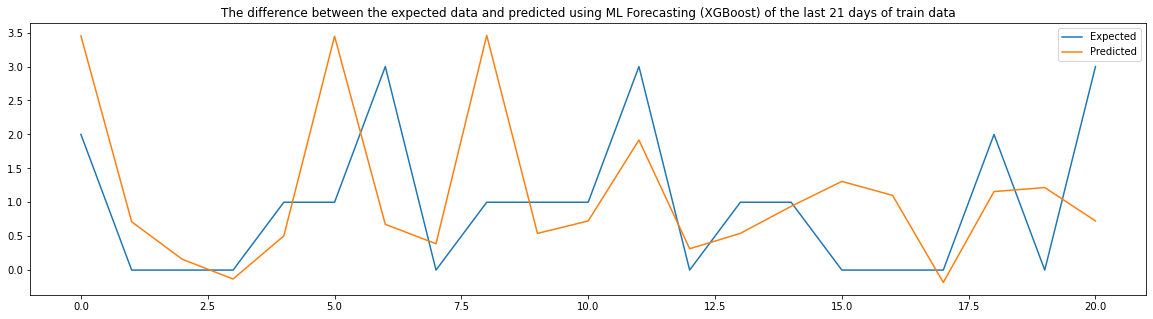

In [99]:
# Load the dataset
first_item_ml = mldata.iloc[1919-120:,1]
first_item_ml = first_item_ml.values.tolist()

# Transform the data into supervised learning
first_item_ml = series_to_supervised(first_item_ml, n_in=7)

# Evaluate error metrics
first_item_mae, first_item_mape, first_item_rmse, first_item_y, first_item_predictions = walk_forward_validation(first_item_ml, 21)

print('RMSE: %.3f' % first_item_rmse)
print('MAE: %.3f' % first_item_mae)
print('MAPE: %.3f' % first_item_mape)

# Plot expected vs preducted
plt.figure(figsize=(20,5))
plt.plot(first_item_y, label='Expected')
plt.plot(first_item_predictions, label='Predicted')
plt.title('The difference between the expected data and predicted using ML Forecasting (XGBoost) of the last 21 days of train data')
plt.legend()
plt.show()

From the above result, we see that the RMSE, MAE, and MAPE is relatively good (on the lower end) compared to all of our previous models. However, this is not fair because we're only using one item of our data. Since it'll take a very long time (20 hours) to run all 30,490 items of our data, we decided we'll calculate the RMSE, MAE, and MAPE for only first 20 items of our data instead (This takes around 25 seconds to run).

In [100]:
ml_all_rmse = []
ml_all_mae = []
ml_all_mape = []

for i in range(10):
    # Load the dataset
    data_row = mldata.iloc[1919-120:,[i+1]]

    # Transform the data into supervised learning
    data_row = series_to_supervised(data_row, n_in=7)

    # Evaluate error metrics
    data_row_mae, data_row_mape, data_row_rmse, data_row_y, data_row_predictions = walk_forward_validation(data_row, 21)
    
    ml_all_rmse.append(data_row_rmse)
    ml_all_mae.append(data_row_mae)
    ml_all_mape.append(data_row_mape)

ml_rmse = np.mean(ml_all_rmse)
ml_mae = np.mean(ml_all_mae)
ml_mape = np.mean(ml_all_mape)

In [181]:
ml_row = {'Method':'ML Forecasting First 10', 'RMSE': ml_rmse, 'MAE': ml_mae, 'MAPE': ml_mape}

error_results = pd.concat([error_results, pd.DataFrame([ml_row])], ignore_index=True)
error_results

,Method,RMSE,MAE,MAPE
0,Naive Method,1.803913,1.427088,1853939292792818.5
1,Average Method,1.348012,1.053608,1544755280891806.25
2,Seasonal Naive,1.876678,1.335059,1702630612063902.0
3,Seasonal Naive Last 21,1.776127,1.244825,1417667805674198.25
4,Drift,1.890484,1.524484,2002462633359685.5
5,Drift Last 21,2.386448,2.005143,2744161791688568.0
6,ML Forecasting First 10,2.603475,1.913154,1840720965320080.5


After running the first 10 rows, we see that the average RMSE, MAE, and MAPE of this model (ML Forecasting) is higher/worse than the previous models. Do note that this is actually not representative of the error metrics of actual total 30,490 items of our data. We would have run the RMSE, MAE, and MAPE for all 30,490 items; however, since it takes 20 hours to run all data, it's not feasible given the time constraint. 

Now that we know what's the error metrics for this model, we want to use this model to predict the next 21 days beyond our train data (the out of sample forecast). For this, we managed to run it on all of 30,490 items of our data. To mitigate the 20 hours run, we did several methods: 

1. We ran the model for 1,000 data each time, which means we have to run the function for about 30 times since there are 30,490 data. Each 1,000 data takes around 30 minutes (on Macbook M1 computer) to 1 hour (on other computers), and we ran multiple 1,000 data on 3 different computers.  

2. We tried to use parallel programming; however, Python is not well equipped for this, and sometimes, sequential programming is better than the parallel in terms of fastesness.

Same as before, we did a one-step forecasting whereby for each data item, we do feature engineering (lag = 7), train our model with the last 120 days of the train data, predict the first step (first day of 21 days), then include that first step predicted value in the train data, refit the model, and predict the second step (second day of 21 days). We repeat that process until we achieve 21 days. 

We provide the function that we run below; however, we commented this function here (in case Prof wanted to run all cells again) to prevent crashing of this notebook.

In [102]:
"""
    The XGBoost Forecast Iterate to make one step prediction on multiple data items
    Arguments:
        total_item: Number items in the dataset that we wanna test (Starting from item 0 or Beauty_1_001_East_1).
        predict_length: Number of days we want to predict
        total_train_data: Number of last days in the train set that we want to train
        train_data: The dataset of our train data.
    Returns:
        Pandas dataframe of the prediction."""
def xgboost_forecast_iterate(total_item, predict_length, total_train_data, train_data):
    sample_result = sample_submission.copy()
    for i in range(total_item):
        series = train_data.iloc[1919 - total_train_data:, [i+1]]
        days = 1920
        for j in range(predict_length):
            values = series.values
            # transform the time series data into supervised learning
            train_series = series_to_supervised(values, n_in=7)
            # split into input and output columns
            trainX, trainy = train_series[:, :-1], train_series[:, -1]
            # fit the model
            model = XGBRegressor(objective='reg:squarederror', n_estimators=500)
            model.fit(trainX, trainy)
            # construct an input for a new prediction
            row = values[-7:].flatten()
            # make a one-step prediction
            yhat = model.predict(np.asarray([row]))
            series.loc[days] = yhat
            days += 1
        sample_result.iloc[i, 1:] = series.iloc[-21:, 0]
    return sample_result.iloc[:total_item,:]

In [103]:
# # On all 30,490 data items. 
# # Don't run this right now. Otherwise, it'll take 20 hours to run.
# xgboost_forecast_iterate(total_item = len(mldata.columns) - 1, predict_length = 21, total_train_data = 120, train_data = mldata)

# On only 2 data items.
xgboost_forecast_iterate(total_item = 2, predict_length = 21, total_train_data = 120, train_data = mldata)

,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
0,Beauty_1_001_East_1,0.875359,1.694194,1.470924,-0.163838,0.597634,0.006378,0.972489,0.860376,1.070863,...,0.297234,0.094973,0.433862,0.898104,0.682798,1.507608,0.589042,2.063237,0.990666,0.511706
1,Beauty_1_002_East_1,0.141774,0.281164,0.322992,0.300860,0.300651,0.306698,0.306576,0.306572,0.306598,...,0.306539,0.306504,0.306447,0.306474,0.306376,0.306289,0.306378,0.306345,0.306349,0.306338


We got an **RMSE of 2.55** on the Kaggle test with this model, which is stronger than the basic models (except Average) but worse than the other models. The poor performance is likely because it's overfitted or that the features are not really fine-tuned.

## Average and weighted average of the models: Combining the "best" models

We tried another "model" whereby we take a certain number of our best models (i.e. models that has highest scores in kaggle) to build a model. We did two methods: (1) Regular average, (2) Weighted average. 

For the regular average, we simply just take the average of each predicted value for each item across all 4 best models (or 4 different predictions). The results is great, and it beats our previous best model (the ETS model). However, when we do this with weighted average, the model performs better.

For the weighted average, we take 4 of our models and total their kaggle scores. Then we divide each score by the total score to get the different proportions. A lower score is better but it will not produce a higher proportion, so we do not allocate proportions to the model they came from. Instead we prioritize the higher proportions to the better models. Then we multiply the entire dataframe by their proportion and add the resulting dataframes together to get the weighted predictions.

The main 4 models that we used are: ETS Rev for 1 year, ETS rev for 2 years, ETS rev for 3 years, and the ARIMA model (AR(0,1,1) trained per id on sales quantity).

In [122]:
# Load the data first!
rev_ets_preds1 = pd.read_csv("Subs/rev_ets.csv")
rev_ets_preds2 = pd.read_csv("Subs/rev_2y_ets.csv")
rev_ets_preds3 = pd.read_csv("Subs/rev_3y_ets.csv")
ss3 = pd.read_csv("Subs/sean_submission3.csv")

The following is the code for the average of 3 of our best models: ETS rev for 2 years, ETS rev for 3 years, and the ARIMA model (AR(0,1,1) trained per id on sales quantity). We also did bagging of some sums including only two of these models.

In [128]:
# Combination of two best models: ETS rev for 3 years and ARIMA model
avg_1 = pd.read_csv('Subs/best_averages.csv')

# Combination of three best models: ETS rev for 2 years and ETS rev for 3 years
avg_2 = pd.read_csv('Subs/best_models_average.csv')

# Combination of ETS rev for 3 years, ETS rev for 2 years, avg_1, and avg_2
avg_3 = pd.read_csv('Subs/best_4_models_average.csv')

avg_models = rev_ets_preds1.append(rev_ets_preds2).append(rev_ets_preds3).append(avg_1).append(avg_2).append(avg_3).groupby('id',as_index=False).agg({'d_1920':'mean', 'd_1921':'mean', 'd_1922':'mean', 'd_1923':'mean', 'd_1924':'mean', 'd_1925':'mean', 'd_1926':'mean', 'd_1927':'mean', 'd_1928':'mean', 'd_1929':'mean', 'd_1930':'mean', 'd_1931':'mean', 'd_1932':'mean', 'd_1933':'mean', 'd_1934':'mean', 'd_1935':'mean', 'd_1936':'mean', 'd_1937':'mean', 'd_1938':'mean', 'd_1939':'mean', 'd_1940':'mean'})
avg_models

,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
0,Beauty_1_001_Central_1,0.382612,0.216381,0.271236,0.267938,0.316095,0.273311,0.246905,0.383300,0.217070,...,0.316784,0.273999,0.247593,0.383989,0.217759,0.272613,0.269316,0.317473,0.274688,0.248282
1,Beauty_1_001_Central_2,0.544300,0.389569,0.349595,0.446866,0.420230,0.501144,0.547399,0.545684,0.390952,...,0.421613,0.502527,0.548782,0.547067,0.392335,0.352361,0.449633,0.422997,0.503911,0.550166
2,Beauty_1_001_Central_3,0.460229,0.467324,0.437935,0.443624,0.557617,0.448335,0.599279,0.447061,0.454156,...,0.544448,0.435167,0.586110,0.433893,0.440988,0.411598,0.417288,0.531280,0.421998,0.572942
3,Beauty_1_001_East_1,0.938957,0.901988,1.017325,0.862179,0.812170,0.901748,1.195222,0.945349,0.908380,...,0.818562,0.908140,1.201614,0.951741,0.914772,1.030108,0.874963,0.824953,0.914532,1.208006
4,Beauty_1_001_East_2,0.874662,0.773133,0.827415,0.724470,0.716063,0.778830,0.874374,0.880620,0.779092,...,0.722021,0.784788,0.880332,0.886579,0.785050,0.839333,0.736388,0.727980,0.790747,0.886291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_827_East_3,5.933587,5.178089,4.576278,3.828367,4.292409,4.751009,6.670619,5.973001,5.217502,...,4.331822,4.790422,6.710032,6.012414,5.256916,4.655105,3.907194,4.371236,4.829836,6.749446
30486,Food_3_827_East_4,3.562136,3.609402,3.456381,3.448071,3.555292,3.484879,3.520827,3.597267,3.644533,...,3.590423,3.520010,3.555958,3.632398,3.679663,3.526643,3.518333,3.625554,3.555141,3.591089
30487,Food_3_827_West_1,4.052809,3.083910,3.207244,2.952554,3.290464,3.820134,3.990997,4.057959,3.089060,...,3.295613,3.825283,3.996146,4.063109,3.094209,3.217544,2.962853,3.300763,3.830433,4.001296
30488,Food_3_827_West_2,2.092156,1.693165,1.614472,1.792705,1.919584,2.005563,1.817320,2.104073,1.705082,...,1.931501,2.017479,1.829236,2.115989,1.716998,1.638305,1.816538,1.943418,2.029396,1.841153


In [129]:
avg_models.to_csv('avg_all_best_models_inc_ets.csv', index=False)

The above model results in **RMSE of 2.22809** on Kaggle, which is better/stronger than our previous best model, which is the ETS rev. The great performance is because we are combining several great models and take the average of it. We can do better if we do weighted average.

The following is the code for the weighted average of 4 of our best models: ETS Rev for 1 year, ETS rev for 2 years, ETS rev for 3 years, and the ARIMA model (AR(0,1,1) trained per id on sales quantity).

In [120]:
## Weighting each model based on the Kaggle score
## We allocate the proportions based on how well the model did
## The worst model would have the highest proportion because it has the lowest score, so instead we give that proportion to the best model
weighted = rev_ets_preds1.drop('id',axis=1).mul(0.248) + rev_ets_preds2.drop('id',axis=1).mul(0.25) + rev_ets_preds3.drop('id',axis=1).mul(0.254) + ss3.drop('id',axis=1).mul(0.248)
weighted['id'] = rev_ets_preds1['id']
weighted = weighted.set_index('id')
weighted

,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
id,,,,,,,,,,,,,,,,,,,,,
Beauty_1_001_East_1,0.942520,0.921239,1.021937,0.895493,0.839817,0.906652,1.158247,0.949370,0.928090,1.028787,...,0.846668,0.913502,1.165098,0.956221,0.934940,1.035638,0.909194,0.853519,0.920353,1.171948
Beauty_1_002_East_1,0.145839,0.074409,0.090696,0.119424,0.186358,0.134967,0.219529,0.143546,0.072117,0.088403,...,0.184065,0.132674,0.217236,0.141253,0.069824,0.086111,0.114839,0.181773,0.130381,0.214943
Beauty_1_003_East_1,0.806965,0.669145,0.719040,0.731829,0.743540,0.774225,1.067425,0.812012,0.674192,0.724087,...,0.748587,0.779272,1.072472,0.817059,0.679239,0.729134,0.741923,0.753634,0.784319,1.077519
Beauty_1_004_East_1,3.218173,1.434980,1.045906,1.160982,1.456830,1.580643,2.459138,3.214790,1.431596,1.042523,...,1.453446,1.577259,2.455755,3.211407,1.428213,1.039139,1.154215,1.450063,1.573876,2.452372
Beauty_1_005_East_1,1.551116,1.103553,1.154823,1.171478,1.213555,1.152351,1.539910,1.573387,1.125825,1.177095,...,1.235826,1.174623,1.562182,1.595659,1.148096,1.199366,1.216021,1.258098,1.196894,1.584454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Food_3_823_West_3,0.541841,0.397943,0.353490,0.488672,0.405879,0.451074,0.432236,0.541983,0.398085,0.353633,...,0.406021,0.451216,0.432379,0.542126,0.398227,0.353775,0.488957,0.406163,0.451359,0.432521
Food_3_824_West_3,0.266778,0.273268,0.266173,0.294757,0.242882,0.229481,0.262403,0.266263,0.272753,0.265658,...,0.242367,0.228966,0.261888,0.265749,0.272238,0.265143,0.293727,0.241853,0.228451,0.261373
Food_3_825_West_3,0.824676,0.790429,0.665031,0.788766,0.684529,0.804041,0.836018,0.821517,0.787270,0.661872,...,0.681370,0.800883,0.832860,0.818359,0.784111,0.658714,0.782448,0.678211,0.797724,0.829701


In [121]:
weighted.to_csv('weighted_averages.csv', index=False)

We got an **RMSE of 2.22697** on the Kaggle test with this weighted average of all best models, which is our strongest model yet. The great performance is likely because we combined all of our best results, and perform a weighted average on all best 4 predictions. 

## Overall Model Selection Results

We can see the performance of different models based on different Kaggle submissions and resulting RMSE scores:

In [134]:
# Load data from CSV
kaggleresults = pd.read_csv('Model Comparisons/kaggleresults-updated.csv')

In [136]:
kaggleresults['model_type'].unique()

array(['ETS', 'ARIMA', 'Drift', 'Averaging', 'Naive', 'Seasonal Naive',
       'Prophet', 'XGBoost', 'Weighted Average Best Models',
       'Average Best Models'], dtype=object)

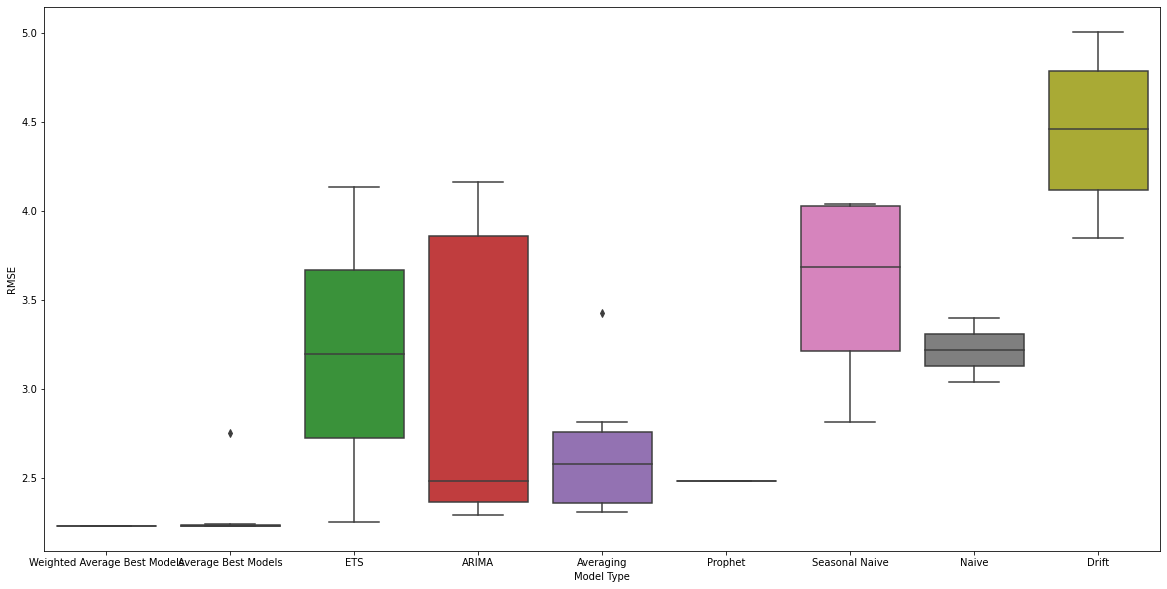

In [143]:
# Specify the order of the boxes
box_order = ['Weighted Average Best Models', 'Average Best Models', 'ETS', 'ARIMA', 'Averaging', 'Prophet', 'Seasonal Naive', 'Naive', 'Drift']

# Set the size of the figure
fig, ax = plt.subplots(figsize=(20, 10))

# Generate the boxplots with adjusted font size for boxplot names and specified order
sns.boxplot(x='model_type', y='RMSE', data=kaggleresults, ax=ax, order=box_order)

# Add x and y axis labels
plt.xlabel('Model Type')
plt.ylabel('RMSE')

# Show the plot
plt.show()


# Quantifying model improvement

To see how our modelling efforts allow FairStorage to make better decisions and maximise profitability, we can compare the results of our better models against the simpler averaging method, which is useful as a benchmark.

To evaluate the accuracy of the forecasting model, we need to generate predictions for the last 21 days of the existing training data and use it as a test dataset for computing the RMSE. To achieve this, the first step is to do a train-test split, where we take away the last 21 days of the existing training data and use it as the test set. This ensures that the test set consists of a contiguous block of data that occurs after the last time point in the training set and reflects how the model would perform on new data in the future. With the test set ready, we can then proceed to re-train the forecasting models on a period of time before the last day of the new training set and compute the differences in RMSE between the models. Finally, we can quantify this difference both as a percentage and in potential monetary terms to assess the impact of the model's accuracy on FairStorage's operations.

Let's start with isolating the test data:

In [18]:
# Data to compare against
reference = train.loc[:, ["id", "d_1899", "d_1900", "d_1901", "d_1902", "d_1903", "d_1904", "d_1905", "d_1906", "d_1907", "d_1908", "d_1909", "d_1910", "d_1911", "d_1912", "d_1913", "d_1914", "d_1915", "d_1916", "d_1917", "d_1918", "d_1919"]]
reference.to_csv('Model Comparisons/reference.csv')

reference

,id,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,2,0,0,0,1,1,3,0,1,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,0,0,0,1,2,2,1,2,1,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,4,2,0,3,0,1,0,5,4,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,1,2,0,1,1,2,1,1,0,...,2,2,2,4,1,0,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,0,2,0,0,0,2,0,0,0,...,1,0,0,1,0,0,0,2,2,0
30486,Food_3_824_West_3,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,0
30487,Food_3_825_West_3,2,4,0,0,0,2,1,0,2,...,0,0,1,0,0,0,1,1,0,2
30488,Food_3_826_West_3,2,0,1,0,3,0,0,1,0,...,0,3,1,3,1,3,0,1,2,1


## Model re-training

Next, let's re-train our models:

### Averaging

In [19]:
arima_comparison = pd.read_csv('Model Comparisons/Sean Arima model.csv')
arima_comparison

,id,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,...,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660,0.986660
1,Beauty_1_002_East_1,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,...,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300,0.191300
2,Beauty_1_003_East_1,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,...,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966,0.232966
3,Beauty_1_004_East_1,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,...,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213,1.918213
4,Beauty_1_005_East_1,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,...,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502,1.126502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,...,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016,0.005016
30486,Food_3_824_West_3,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,...,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655,0.171655
30487,Food_3_825_West_3,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,...,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426,1.103426
30488,Food_3_826_West_3,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,...,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162,1.037162


In [20]:
last_week = train[["id","d_1892" ,"d_1893" ,"d_1894" ,"d_1895" , "d_1896" ,"d_1897", "d_1898"]]
last_week2 = last_week.merge(last_week, on ="id")
last_week3 = last_week2.merge(last_week, on ="id")
last_week3.columns = arima_comparison.columns
last_week3.to_csv("Model Comparisons/jonjosh_mod.csv", index = False)
last_week3_avg = last_week3.copy()
average_lastweek = last_week.mean(axis = 1)
for i in range(len(last_week3_avg.columns)-1):
    last_week3_avg.iloc[:,i+1] = average_lastweek
last_week3_avg.to_csv("Model Comparisons/jonjosh_mod.csv", index = False)

last_week3_avg

/var/folders/fv/tvh892ks5mz1ls6_l14p3kzm0000gn/T/ipykernel_6984/3337063552.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_lastweek = last_week.mean(axis = 1)


,id,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,...,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429
1,Beauty_1_002_East_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Beauty_1_003_East_1,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,...,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714
3,Beauty_1_004_East_1,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
4,Beauty_1_005_East_1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30486,Food_3_824_West_3,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,...,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
30487,Food_3_825_West_3,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,...,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571,1.428571
30488,Food_3_826_West_3,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,...,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857,1.142857


### ARIMA/ETS

Training code is omitted for ARIMA and ETS as this is computationally intensive, but we can import the results here:

## Comparison

Let's start comparing the results together.

### Defining helper functions

In [21]:
# A function that splits the id in submission-format dataframes into
# separate columns for each categorical variable, to assist in
# analysis

def split_id_string(submission_data, drop_id=False):
    category = []
    subcat_id = []
    item_id = []
    region = []
    store_id = []

    split_submission = submission_data.copy()

    for c in range(len(split_submission)):
        split = split_submission['id'].values[c].split('_')
        category.append(split[0])
        subcat_id.append(split[1])
        item_id.append(split[2])
        region.append(split[3])
        store_id.append(split[4])
    
    split_submission.insert(loc=0, column='category', value=category)
    split_submission.insert(loc=1, column='subcat_id', value=subcat_id)
    split_submission.insert(loc=2, column='item_id', value=item_id)
    split_submission.insert(loc=3, column='region', value=region)
    split_submission.insert(loc=4, column='store_id', value=store_id)

    if drop_id == True:
        split_submission.drop(columns='id')
    
    return split_submission

In [22]:
# To check RMSE difference between models
from sklearn.metrics import mean_squared_error

def rmse_check(reference_df, comp_df, split=False):
    if split == True:
        lim = 6
    else: lim = 1
    
    # isolate values, wtihout ID
    refval = reference_df.iloc[0].iloc[lim:].values
    compval = comp_df.iloc[0].iloc[lim:].values

    # calculate RMSE
    return np.sqrt(mean_squared_error(refval, compval))

In [23]:
# To check RMSE difference between models when specific ID variables
# have the same value
def idcat_check(reference_df, comp_df, category_name, idcat_name):
    refval = reference_df
    compval = comp_df
    
    if len(reference_df.columns) == 22:
        refval = split_id_string(refval)
        compval = split_id_string(compval)

    checkval = rmse_check(refval[refval[category_name] == idcat_name], compval[compval[category_name] == idcat_name], split=True)

    return checkval

In [24]:
# A diagnostic function to compare a dataframe with predictions from a
# model with a reference dataframe

def check_against_reference(reference_df, comp_df):
    # category
    beauty = idcat_check(reference_df, comp_df, 'category', 'Beauty')
    cleaning = idcat_check(reference_df, comp_df, 'category', 'Cleaning')
    food = idcat_check(reference_df, comp_df, 'category', 'Food')

    # region
    east = idcat_check(reference_df, comp_df, 'region', 'East')
    central = idcat_check(reference_df, comp_df, 'region', 'Central')
    west = idcat_check(reference_df, comp_df, 'region', 'West')

    print('RMSE for beauty products: ' + str(beauty))
    print('RMSE for cleaning products: ' + str(cleaning))
    print('RMSE for food products: ' + str(food))
    print('RMSE for East region: ' + str(east))
    print('RMSE for Central region: ' + str(central))
    print('RMSE for West region products: ' + str(west))
    return np.array([beauty, cleaning, food, east, central, west])

In [25]:
# A diagnostic function to compare two dataframes which are
# results from different models

def compare_against_reference(reference_df, comp_dfA, comp_dfB, comp_dfA_name="Model A", comp_dfB_name="Model B"):
    # percentage improvement
    def percent_improve(RMSE1, RMSE2):
        return abs((RMSE2 - RMSE1)/RMSE2 * 100)
    
    # category
    beauty_A = idcat_check(reference_df, comp_dfA, 'category', 'Beauty')
    beauty_B = idcat_check(reference_df, comp_dfB, 'category', 'Beauty')
    beauty_imp = percent_improve(beauty_A, beauty_B)

    cleaning_A = idcat_check(reference_df, comp_dfA, 'category', 'Cleaning')
    cleaning_B = idcat_check(reference_df, comp_dfB, 'category', 'Cleaning')
    cleaning_imp = percent_improve(cleaning_A, cleaning_B)

    food_A = idcat_check(reference_df, comp_dfA, 'category', 'Food')
    food_B = idcat_check(reference_df, comp_dfB, 'category', 'Food')
    food_imp = percent_improve(food_A, food_B)

    # region
    east_A = idcat_check(reference_df, comp_dfA, 'region', 'East')
    east_B = idcat_check(reference_df, comp_dfB, 'region', 'East')
    east_imp = percent_improve(east_A, east_B)

    central_A = idcat_check(reference_df, comp_dfA, 'region', 'Central')
    central_B = idcat_check(reference_df, comp_dfB, 'region', 'Central')
    central_imp = percent_improve(central_A, central_B)

    west_A = idcat_check(reference_df, comp_dfA, 'region', 'West')
    west_B = idcat_check(reference_df, comp_dfB, 'region', 'West')
    west_imp = percent_improve(west_A, west_B)

    overall_A = rmse_check(reference_df, comp_dfA)
    overall_B = rmse_check(reference_df, comp_dfB)
    overall = percent_improve(overall_A, overall_B)

    print('RMSE of ' + comp_dfA_name + ' overall: ' + str(overall_A))
    print('RMSE of ' + comp_dfB_name + ' overall: ' + str(overall_B))
    if beauty_A < beauty_B:
        print(comp_dfA_name + ' is better than ' + comp_dfB_name + ' by ' + str(round(overall, 2)) + '% \n')
    if beauty_B < beauty_A:
        print(comp_dfB_name + ' is better than ' + comp_dfA_name + ' by ' + str(round(overall, 2)) + '% \n')

    print('RMSE of ' + comp_dfA_name + ' for beauty products: ' + str(beauty_A))
    print('RMSE of ' + comp_dfB_name + ' for beauty products: ' + str(beauty_B))
    if beauty_A < beauty_B:
        print(comp_dfA_name + ' is better than ' + comp_dfB_name + ' by ' + str(round(beauty_imp, 2)) + '% \n')
    if beauty_B < beauty_A:
        print(comp_dfB_name + ' is better than ' + comp_dfA_name + ' by ' + str(round(beauty_imp, 2)) + '% \n')

    print('RMSE of ' + comp_dfA_name + ' for cleaning products: ' + str(cleaning_A))
    print('RMSE of ' + comp_dfB_name + ' for cleaning products: ' + str(cleaning_B))
    if cleaning_A < cleaning_B:
        print(comp_dfA_name + ' is better than ' + comp_dfB_name + ' by ' + str(round(cleaning_imp, 2)) + '% \n')
    if cleaning_B < cleaning_A:
        print(comp_dfB_name + ' is better than ' + comp_dfA_name + ' by ' + str(round(cleaning_imp, 2)) + '% \n')

    print('RMSE of ' + comp_dfA_name + ' for food products: ' + str(food_A))
    print('RMSE of ' + comp_dfB_name + ' for food products: ' + str(food_B))
    if food_A < food_B:
        print(comp_dfA_name + ' is better than ' + comp_dfB_name + ' by ' + str(round(food_imp, 2)) + '% \n')
    if food_B < food_A:
        print(comp_dfB_name + ' is better than ' + comp_dfA_name + ' by ' + str(round(food_imp, 2)) + '% \n')
    
    print('RMSE of ' + comp_dfA_name + ' for East region: ' + str(east_A))
    print('RMSE of ' + comp_dfB_name + ' for East region: ' + str(east_B))
    if east_A < east_B:
        print(comp_dfA_name + ' is better than ' + comp_dfB_name + ' by ' + str(round(east_imp, 2)) + '% \n')
    if east_B < east_A:
        print(comp_dfB_name + ' is better than ' + comp_dfA_name + ' by ' + str(round(east_imp, 2)) + '% \n')

    print('RMSE of ' + comp_dfA_name + ' for Central region: ' + str(central_A))
    print('RMSE of ' + comp_dfB_name + ' for Central region: ' + str(central_B))
    if central_A < central_B:
        print(comp_dfA_name + ' is better than ' + comp_dfB_name + ' by ' + str(round(central_imp, 2)) + '% \n')
    if central_B < central_A:
        print(comp_dfB_name + ' is better than ' + comp_dfA_name + ' by ' + str(round(central_imp, 2)) + '% \n')

    print('RMSE of ' + comp_dfA_name + ' for West region: ' + str(west_A))
    print('RMSE of ' + comp_dfB_name + ' for West region: ' + str(west_B))
    if west_A < west_B:
        print(comp_dfA_name + ' is better than ' + comp_dfB_name + ' by ' + str(round(west_imp, 2)) + '% \n')
    if west_B < west_A:
        print(comp_dfB_name + ' is worse than ' + comp_dfA_name + ' by ' + str(round(west_imp, 2)) + '% \n')


### Averaging vs ARIMA

In [26]:
compare_against_reference(reference, last_week3_avg, arima_comparison, "Averaging", "ARIMA")

RMSE of Averaging overall: 1.2149857925879117
RMSE of ARIMA overall: 1.046014135712788
ARIMA is better than Averaging by 16.15% 

RMSE of Averaging for beauty products: 1.2149857925879117
RMSE of ARIMA for beauty products: 1.046014135712788
ARIMA is better than Averaging by 16.15% 

RMSE of Averaging for cleaning products: 0.6494372236659931
RMSE of ARIMA for cleaning products: 0.5832692860226616
ARIMA is better than Averaging by 11.34% 

RMSE of Averaging for food products: 1.087967586551987
RMSE of ARIMA for food products: 1.0241719751648
ARIMA is better than Averaging by 6.23% 

RMSE of Averaging for East region: 1.2149857925879117
RMSE of ARIMA for East region: 1.046014135712788
ARIMA is better than Averaging by 16.15% 

RMSE of Averaging for Central region: 0.659828879073858
RMSE of ARIMA for Central region: 0.660702378661655
Averaging is better than ARIMA by 0.13% 

RMSE of Averaging for West region: 0.5593971487843205
RMSE of ARIMA for West region: 0.5668504067716015
Averaging i

## Quantifying cost savings

It's important to quantify the results of our forecasting models in terms of actual cost savings for the FairStorage supermarket because it provides a concrete measure of the business value of our models. By estimating the potential monetary benefits of our forecasting models, we can better understand their impact on the bottom line and make data-driven decisions about how to improve their performance. This can also help us prioritize which models to focus on and justify the investment in data science and machine learning initiatives.

Let's start by reformatting the data into a weekly format so that we can get price data from the `prices` dataset:

In [27]:
# Function to reformat data
def to_prices_format(predictions_df):
    # Assuming your dataframes are named: predictions_df, prices_df, calendar_df

    # Step 1: Merge 'predictions_df' with 'calendar' on the 'd' column
    merged_df = predictions_df.melt(id_vars=['id'], var_name='d', value_name='prediction')
    merged_df = merged_df.merge(calendar[['d', 'wm_yr_wk']], on='d', how='left')

    # Step 2: Calculate the weekly average for each product
    weekly_avg = merged_df.groupby(['id', 'wm_yr_wk'])['prediction'].mean().reset_index()

    # Step 3: Pivot the dataframe
    final_df = weekly_avg.pivot_table(index='id', columns='wm_yr_wk', values='prediction').reset_index()

    return weekly_avg

In [28]:
# Get price data for items featured in reference data
reference_prices = to_prices_format(reference)
reference_prices = reference_prices.merge(price)
reference_prices

,id,wm_yr_wk,prediction,store_id,item_id,sell_price
0,Beauty_1_001_Central_1,11611,0.333333,Central_1,Beauty_1_001,8.26
1,Beauty_1_001_Central_1,11612,0.285714,Central_1,Beauty_1_001,8.26
2,Beauty_1_001_Central_1,11613,0.571429,Central_1,Beauty_1_001,8.26
3,Beauty_1_001_Central_1,11614,0.000000,Central_1,Beauty_1_001,8.26
4,Beauty_1_001_Central_2,11611,0.333333,Central_2,Beauty_1_001,8.26
...,...,...,...,...,...,...
121955,Food_3_827_West_2,11614,2.000000,West_2,Food_3_827,1.00
121956,Food_3_827_West_3,11611,0.000000,West_3,Food_3_827,1.00
121957,Food_3_827_West_3,11612,0.000000,West_3,Food_3_827,1.00
121958,Food_3_827_West_3,11613,0.000000,West_3,Food_3_827,1.00


In [29]:
# Get price data for items featured in averaging
last_week3_avg_prices = to_prices_format(last_week3_avg)
last_week3_avg_prices = last_week3_avg_prices.merge(price)
last_week3_avg_prices

,id,wm_yr_wk,prediction,store_id,item_id,sell_price
0,Beauty_1_001_Central_1,11611,0.285714,Central_1,Beauty_1_001,8.26
1,Beauty_1_001_Central_1,11612,0.285714,Central_1,Beauty_1_001,8.26
2,Beauty_1_001_Central_1,11613,0.285714,Central_1,Beauty_1_001,8.26
3,Beauty_1_001_Central_1,11614,0.285714,Central_1,Beauty_1_001,8.26
4,Beauty_1_001_Central_2,11611,0.285714,Central_2,Beauty_1_001,8.26
...,...,...,...,...,...,...
121955,Food_3_827_West_2,11614,3.142857,West_2,Food_3_827,1.00
121956,Food_3_827_West_3,11611,1.285714,West_3,Food_3_827,1.00
121957,Food_3_827_West_3,11612,1.285714,West_3,Food_3_827,1.00
121958,Food_3_827_West_3,11613,1.285714,West_3,Food_3_827,1.00


In [30]:
arima_comparison_prices = to_prices_format(arima_comparison)
arima_comparison_prices = arima_comparison_prices.merge(price)
arima_comparison_prices

,id,wm_yr_wk,prediction,store_id,item_id,sell_price
0,Beauty_1_001_Central_1,11611,0.279840,Central_1,Beauty_1_001,8.26
1,Beauty_1_001_Central_1,11612,0.279840,Central_1,Beauty_1_001,8.26
2,Beauty_1_001_Central_1,11613,0.279840,Central_1,Beauty_1_001,8.26
3,Beauty_1_001_Central_1,11614,0.279840,Central_1,Beauty_1_001,8.26
4,Beauty_1_001_Central_2,11611,0.432788,Central_2,Beauty_1_001,8.26
...,...,...,...,...,...,...
121955,Food_3_827_West_2,11614,2.963021,West_2,Food_3_827,1.00
121956,Food_3_827_West_3,11611,2.006862,West_3,Food_3_827,1.00
121957,Food_3_827_West_3,11612,2.006862,West_3,Food_3_827,1.00
121958,Food_3_827_West_3,11613,2.006862,West_3,Food_3_827,1.00


Let's calculate the actual revenue the store earned from the test set and compare against predicted revenue using the different models, showing how different models help FairStorage make better stocking decisions:

In [31]:
# Calculate projected revenue with averaging
real_rev = sum(reference_prices['prediction'] * reference_prices['sell_price'])
print('Actual revenue (test data): ' + str(round(real_rev, 2)))

Actual revenue (test data): 551000.02


In [32]:
# Calculate projected revenue with averaging
average_rev = sum(last_week3_avg_prices['prediction'] * last_week3_avg_prices['sell_price'])
diff_ave_real = real_rev - average_rev
print('Projected revenue with averaging: $' + str(round(average_rev, 2)))
print('Difference from real: $' + str(round(diff_ave_real, 2)))

Projected revenue with averaging: $565012.42
Difference from real: $-14012.41


In [33]:
# Calculate projected revenue with ARIMA
arima_rev = sum(arima_comparison_prices['prediction'] * arima_comparison_prices['sell_price'])
diff_arima_real = real_rev - arima_rev
print('Projected revenue with ARIMA: $' + str(round(arima_rev, 2)))
print('Difference from real: $' + str(round(diff_arima_real, 2)))

Projected revenue with ARIMA: $551861.37
Difference from real: $-861.35


In [34]:
print('Cost savings with using ARIMA: $' + str(abs(diff_ave_real - diff_arima_real)))
print('Percentage of loss prevented by stocking to ARIMA-predicted demand: ' + str(round(100 - ((diff_arima_real / diff_ave_real) * 100), 2)) + '%')

Cost savings with using ARIMA: $13151.055729133426
Percentage of loss prevented by stocking to ARIMA-predicted demand: 93.85%


Based on the results of our forecasting models, we can see that ARIMA provides a more accurate projection of revenue compared to averaging. ARIMA not only had a smaller difference from the actual revenue, but also saved $13151.06 in potential cost savings compared to averaging. This translates to a 93.85% loss prevention by stocking to ARIMA-predicted demand. These results demonstrate the value of using data science to optimize demand forecasting and highlight the potential for significant cost savings by leveraging advanced machine learning techniques.